In [1]:
import torch

In [2]:
# this example creates sample data for growth curve represented by equation y=1.08 raised to x where x is an integer from 0,50

torch.manual_seed(0)
observations = 2048
train_data=torch.zeros((observations, 2))
train_data[:,0]=50*torch.rand(observations)
train_data[:,1]=1.08**train_data[:,0]

In [3]:
print(train_data)
train_data.shape

tensor([[24.8128,  6.7505],
        [38.4111, 19.2240],
        [ 4.4239,  1.4056],
        ...,
        [29.3746,  9.5898],
        [41.3159, 24.0399],
        [14.5458,  3.0632]])


torch.Size([2048, 2])

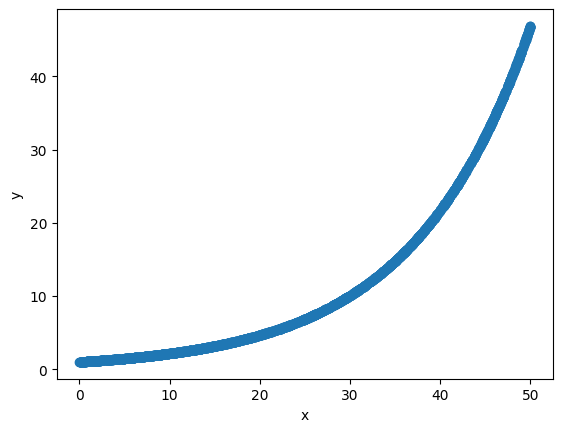

In [4]:
# Plot the graph to see its exponential nature
import matplotlib.pyplot as plt
plt.scatter(train_data[:,0], train_data[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [5]:
# Assignment : Modify the example so that the relation between x and y is y = sin(x)
# Set the value of x between –5 and 5

train_data1=torch.zeros((observations, 2))
train_data1[:,0] = 10* (torch.rand(observations)- 0.5)
train_data1[:,1] = torch.sin(train_data1[:,0])

In [7]:
print(train_data1)
train_data1.shape

tensor([[-2.6130, -0.5043],
        [-1.4439, -0.9920],
        [-3.2361,  0.0944],
        ...,
        [ 2.1737,  0.8237],
        [ 1.1930,  0.9295],
        [-4.3641,  0.9400]])


torch.Size([2048, 2])

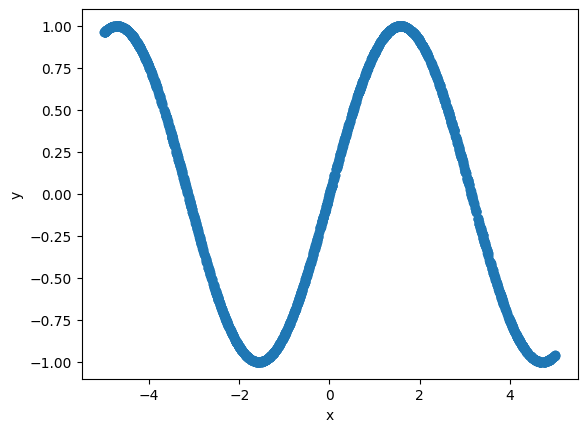

In [8]:
# Plot the graph to see its Sine-wave nature

plt.scatter(train_data1[:,0], train_data1[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# how to create & access the sample data in batches?
# We can use the DataLoader class of PyTorch for that

from torch.utils.data import DataLoader
batch_size= 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)

# To access batch0
batch0=next(iter(train_loader))
print(batch0)
batch0.shape

tensor([[ 0.3502,  1.0273],
        [34.6425, 14.3841],
        [33.0733, 12.7477],
        [37.8458, 18.4056],
        [37.8474, 18.4078],
        [33.5004, 13.1738],
        [ 3.0980,  1.2692],
        [32.6420, 12.3316],
        [30.5034, 10.4602],
        [42.0226, 25.3837],
        [39.2565, 20.5164],
        [ 4.6602,  1.4314],
        [16.9610,  3.6889],
        [42.8959, 27.1484],
        [18.9863,  4.3112],
        [46.4489, 35.6859],
        [45.0543, 32.0541],
        [25.9545,  7.3705],
        [44.1880, 29.9869],
        [44.5339, 30.7958],
        [15.3591,  3.2611],
        [16.7406,  3.6269],
        [ 9.0535,  2.0073],
        [23.3343,  6.0245],
        [24.4594,  6.5694],
        [29.8973,  9.9834],
        [23.2484,  5.9848],
        [ 1.7409,  1.1434],
        [32.3203, 12.0300],
        [48.5187, 41.8484],
        [23.1070,  5.9200],
        [42.8136, 26.9769],
        [ 5.6453,  1.5441],
        [19.1775,  4.3751],
        [28.6506,  9.0701],
        [35.3760, 15

torch.Size([128, 2])

Now that the training dataset is ready, we will create a discriminator network and a generator network. The discriminator network is a binary classifier whose job is to classify the samples into either real or fake.
A generator network will also be created that tries to create data points(x,y) that are indistinguishable from those in the training set.

In [10]:
# DISCRIMINATOR network

# The hidden layers have 256, 128, and 64 neurons in them, respectively. There
# is nothing magical about these numbers, and you can easily change them and
# have similar results as long as they are in a reasonable range.

import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"
discriminator = nn.Sequential(
    nn.Linear(2,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()
).to(device)



In [11]:
# GENERATOR network

generator = nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32, 2)).to(device)

In [12]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(discriminator.parameters(),lr=lr)
optimG=torch.optim.Adam(generator.parameters(),lr=lr)

In [13]:
mse=nn.MSELoss()

def performance(fake_samples):
    real=1.08**fake_samples[:,0]
    mseloss=mse(fake_samples[:,1],real)
    return mseloss

In [14]:
class EarlyStop:
    def __init__(self, patience=1000):
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):
        if gdif < self.min_gdif:
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:
            return True
        else:
            return False
stopper=EarlyStop()

Train the GANs

In [15]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)
fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [16]:
def train_D_on_real(real_samples):
    real_samples = real_samples.to(device)
    optimD.zero_grad()
    out_D = discriminator(real_samples)
    loss_D = loss_fn(out_D,real_labels)
    loss_D.backward()
    optimD.step()
    return loss_D

In [17]:
def train_D_on_fake():
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples = generator(noise)     #A
    optimD.zero_grad()
    out_D = discriminator(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [18]:
def train_G():
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=generator(noise)    #A
    out_G = discriminator(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples

In [19]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 1, G loss: 0.7379915873209636, D loss 0.8932820638020833


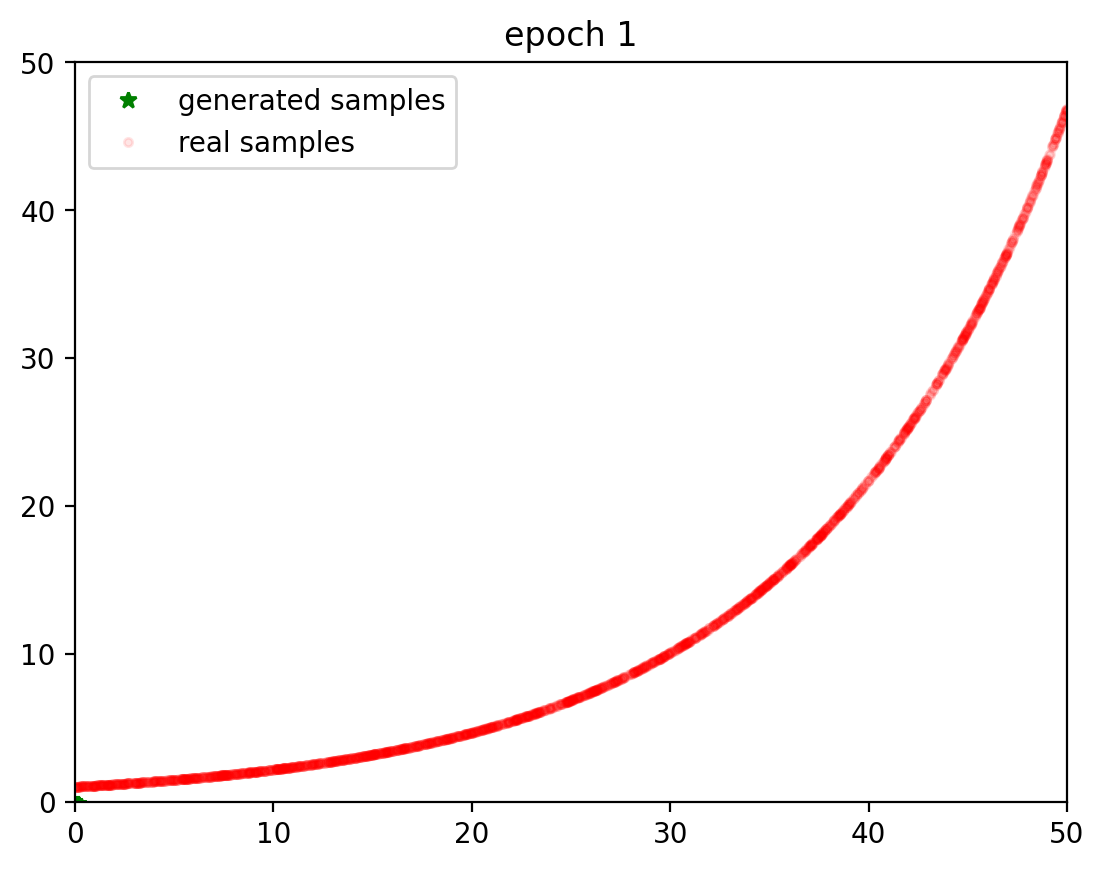

at epoch 25, G loss: 1.9213915506998698, D loss 0.7406089782714844


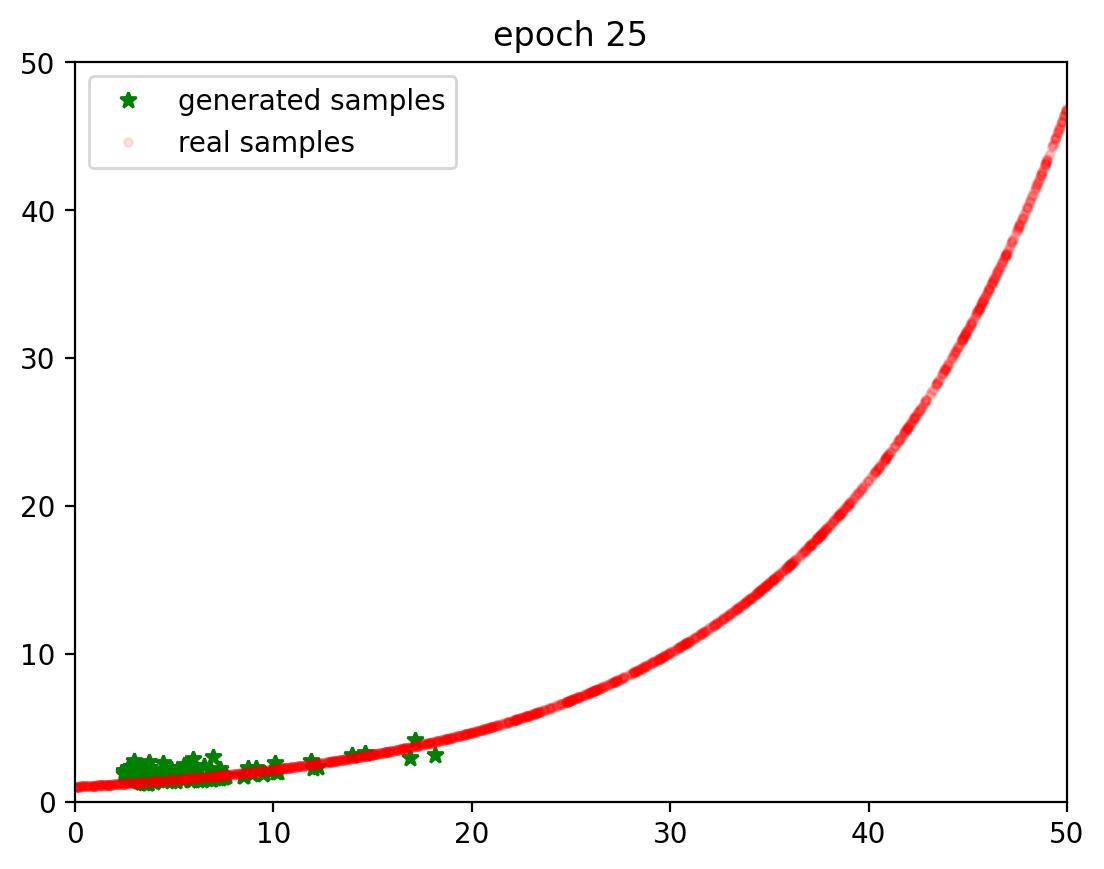

at epoch 50, G loss: 1.1952762603759766, D loss 1.0643571853637694


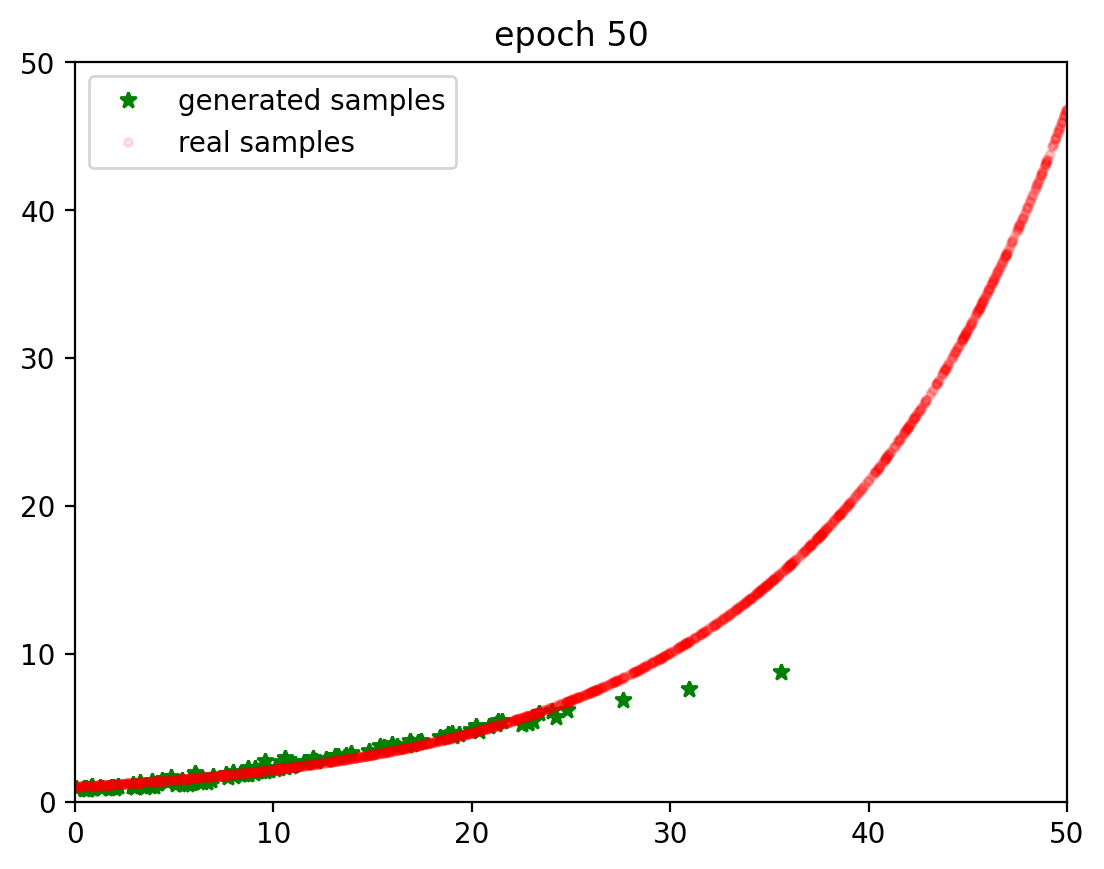

at epoch 75, G loss: 1.0674663543701173, D loss 1.154372787475586


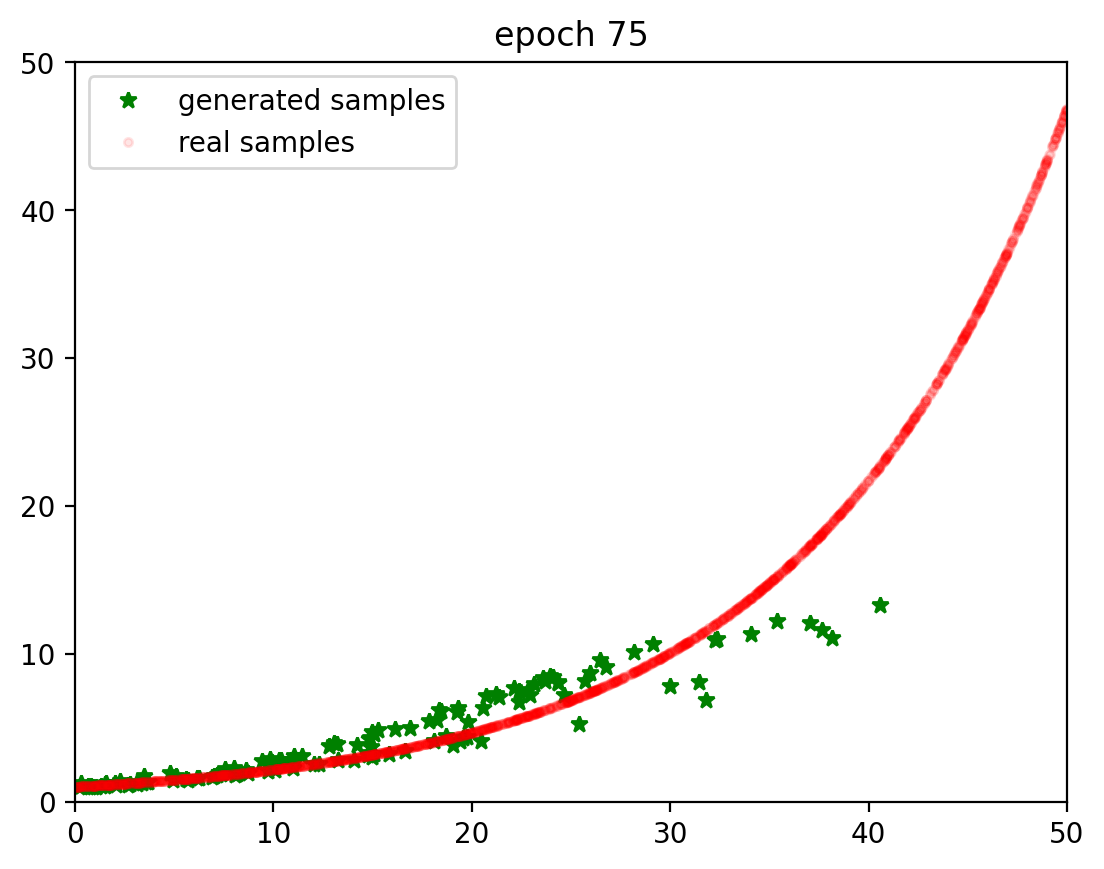

at epoch 100, G loss: 0.9705701192220052, D loss 1.2452732086181642


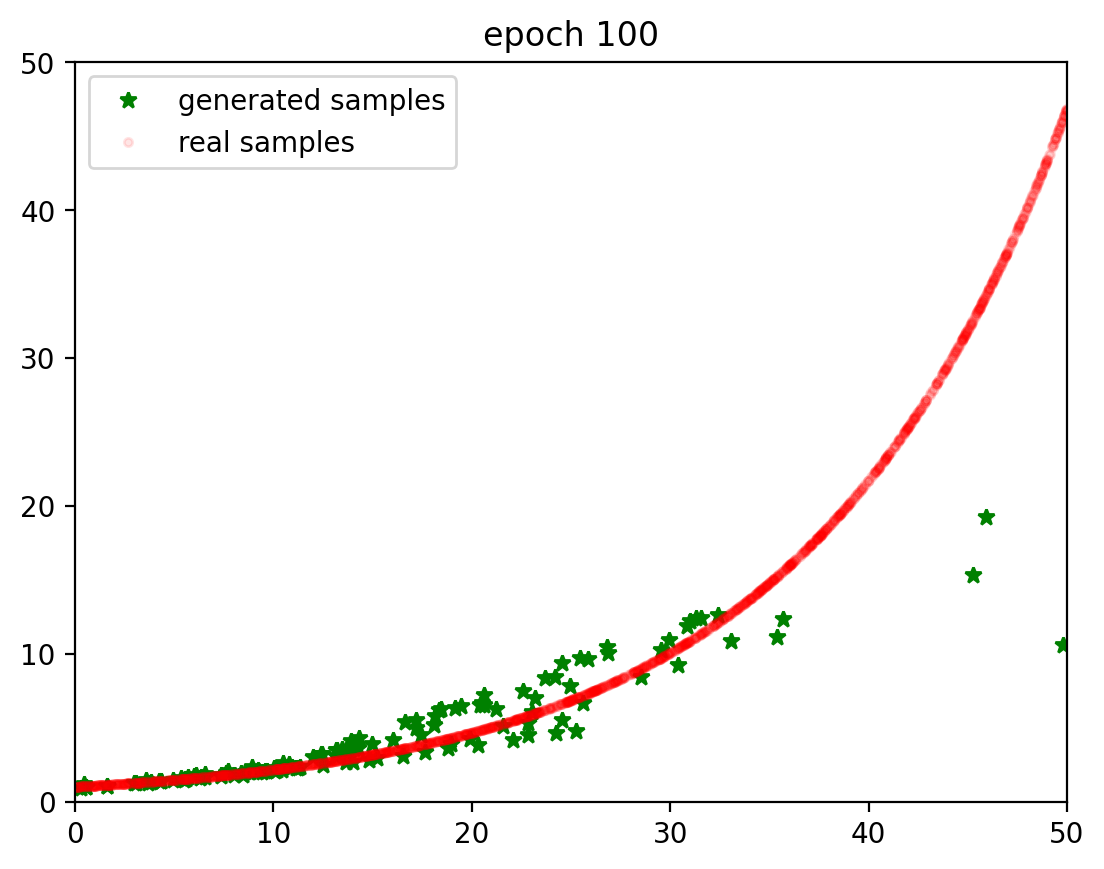

at epoch 125, G loss: 0.8525742848714193, D loss 1.3408873240152994


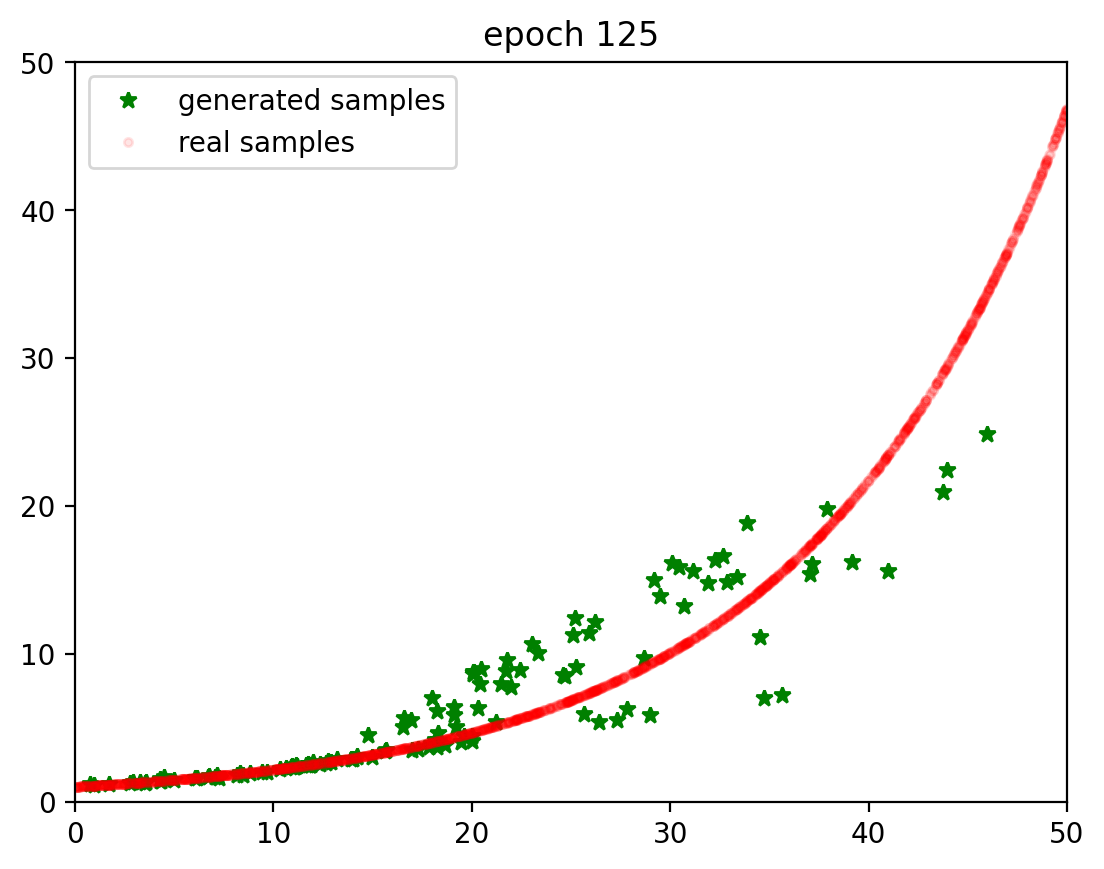

at epoch 150, G loss: 0.8230422337849935, D loss 1.3997739156087239


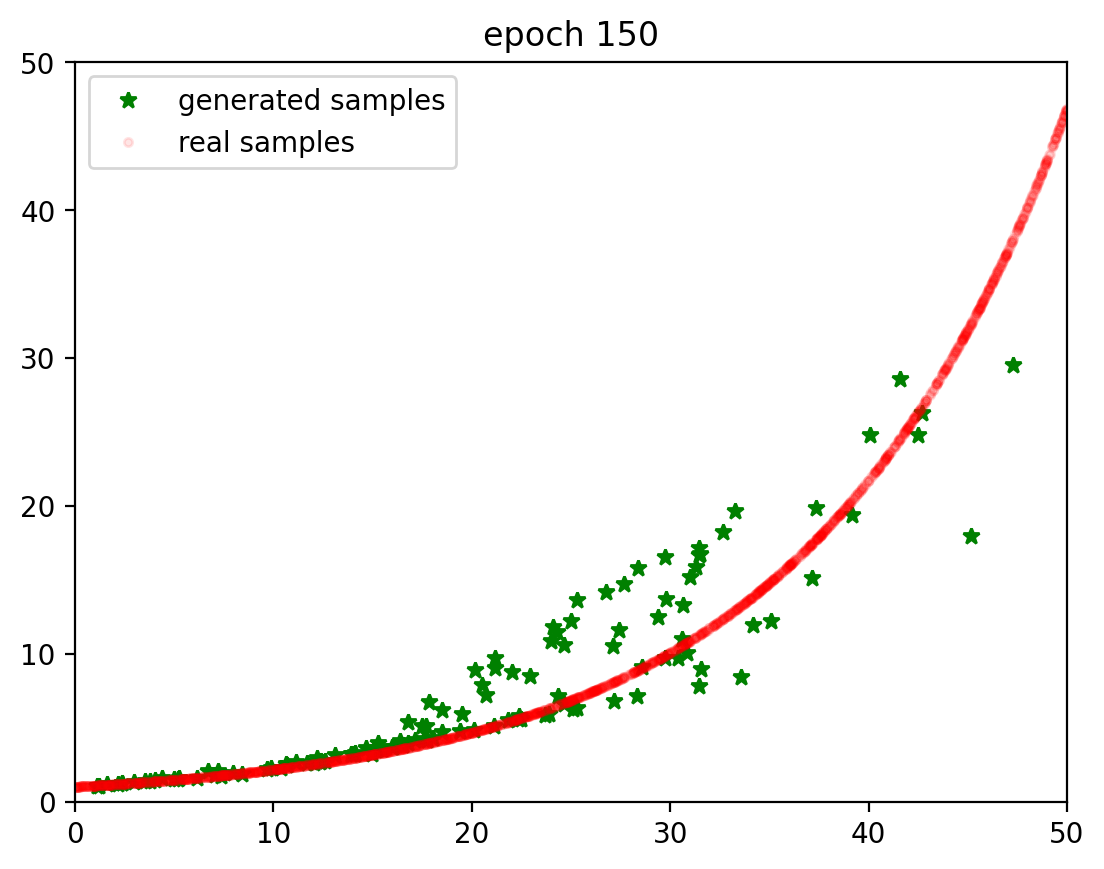

at epoch 175, G loss: 0.7772286732991537, D loss 1.4565447489420573


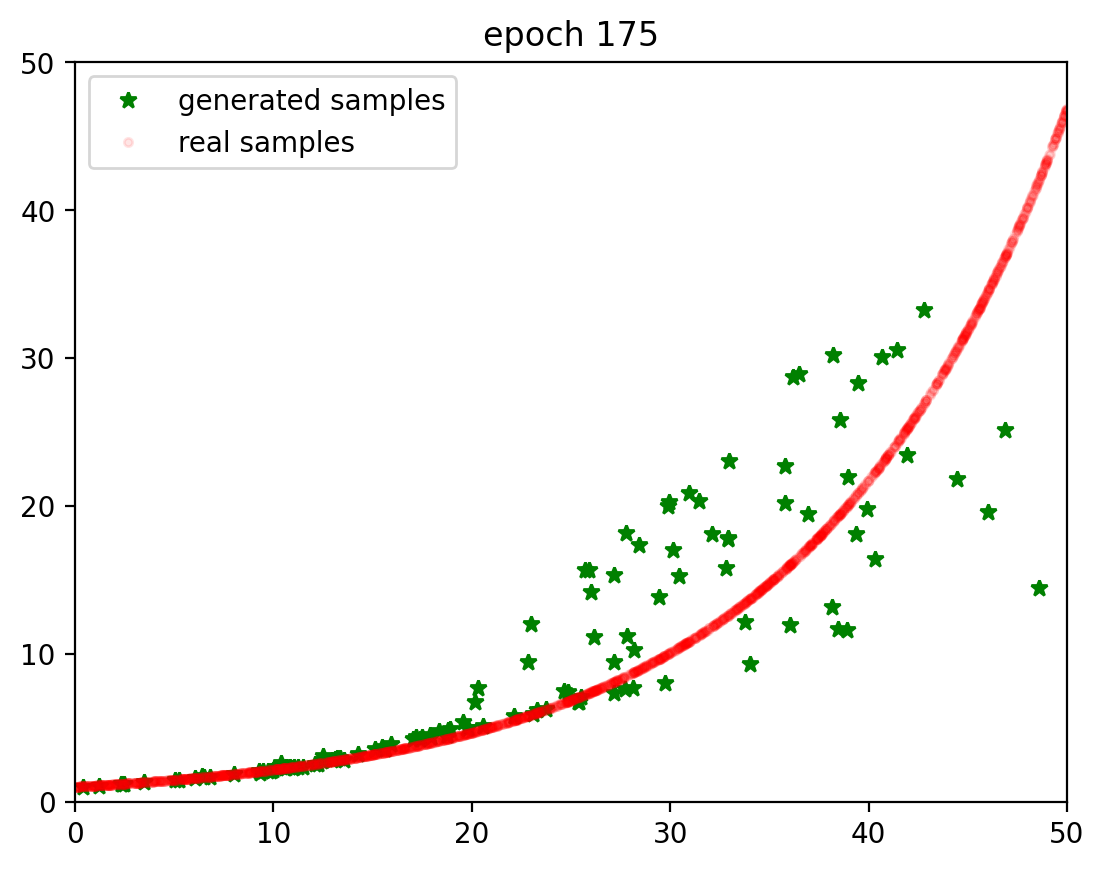

at epoch 200, G loss: 0.7726917266845703, D loss 1.463979721069336


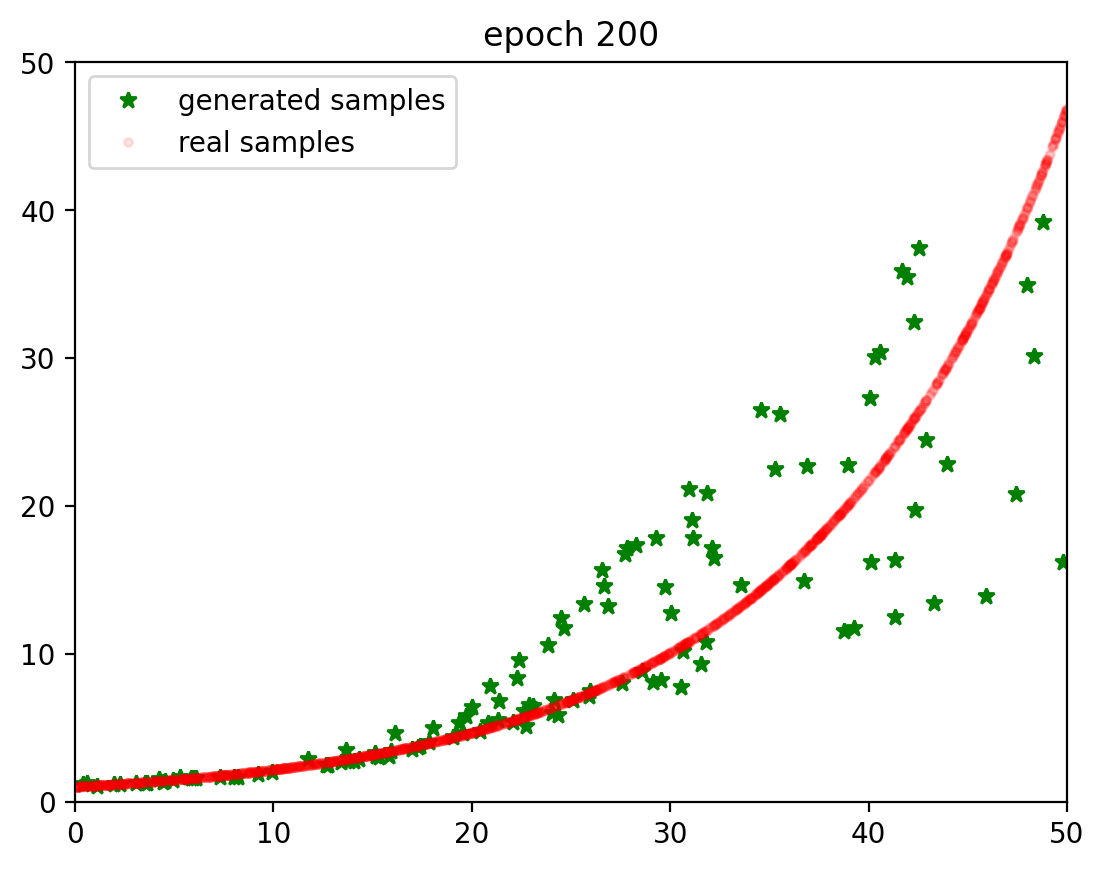

at epoch 225, G loss: 0.7678127924601237, D loss 1.4743366241455078


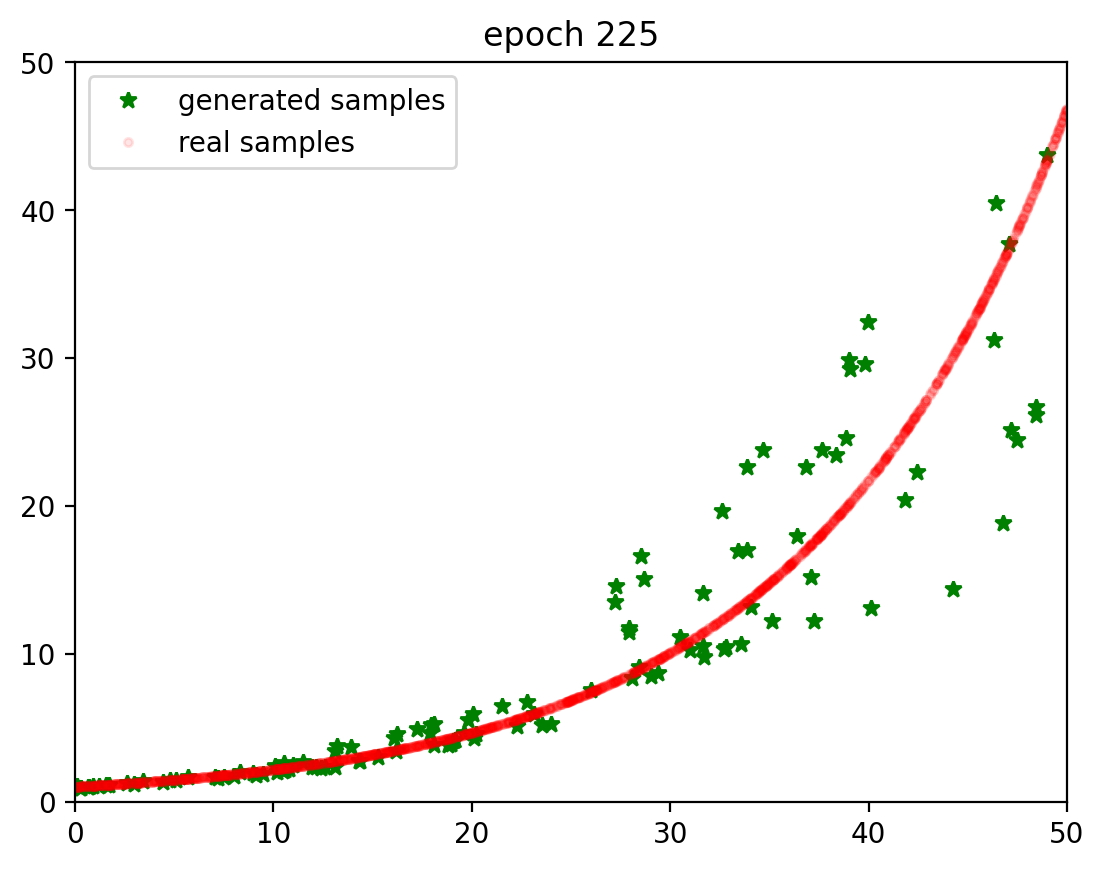

at epoch 250, G loss: 0.7681039174397787, D loss 1.4706370035807292


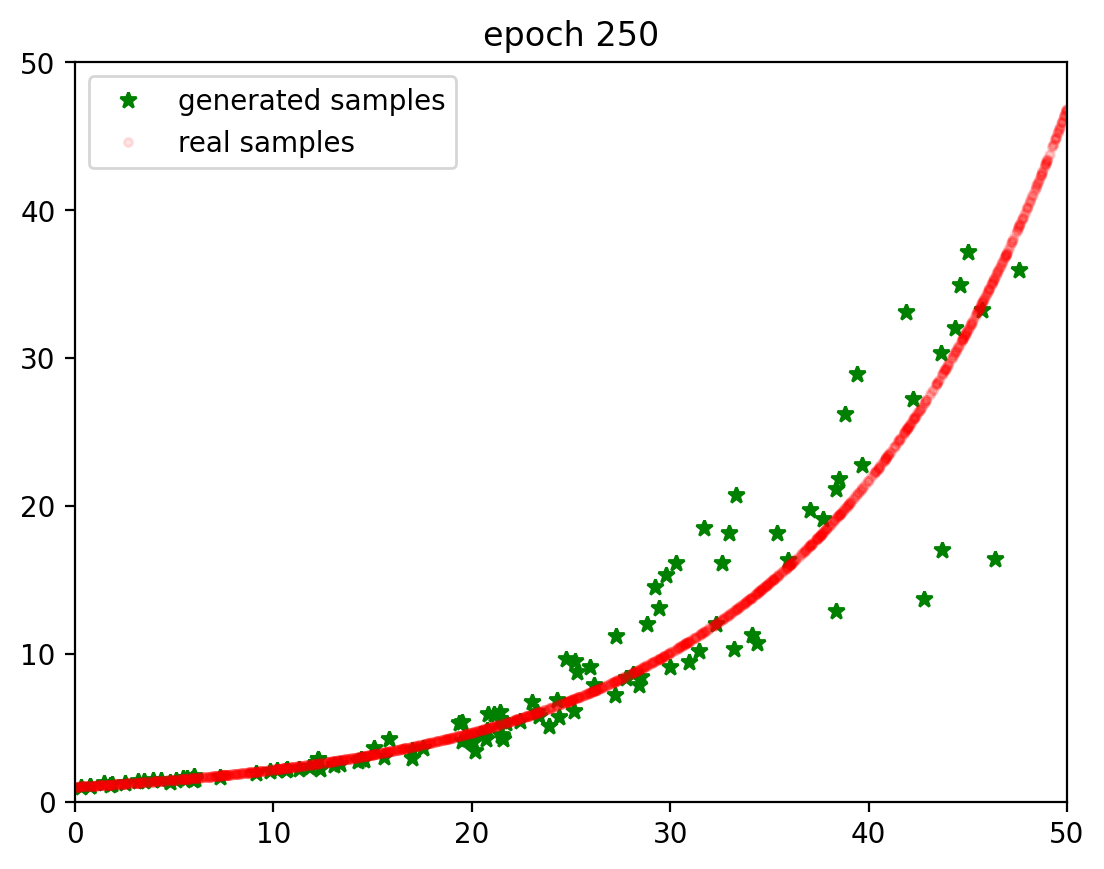

at epoch 275, G loss: 0.7578712463378906, D loss 1.4762468973795573


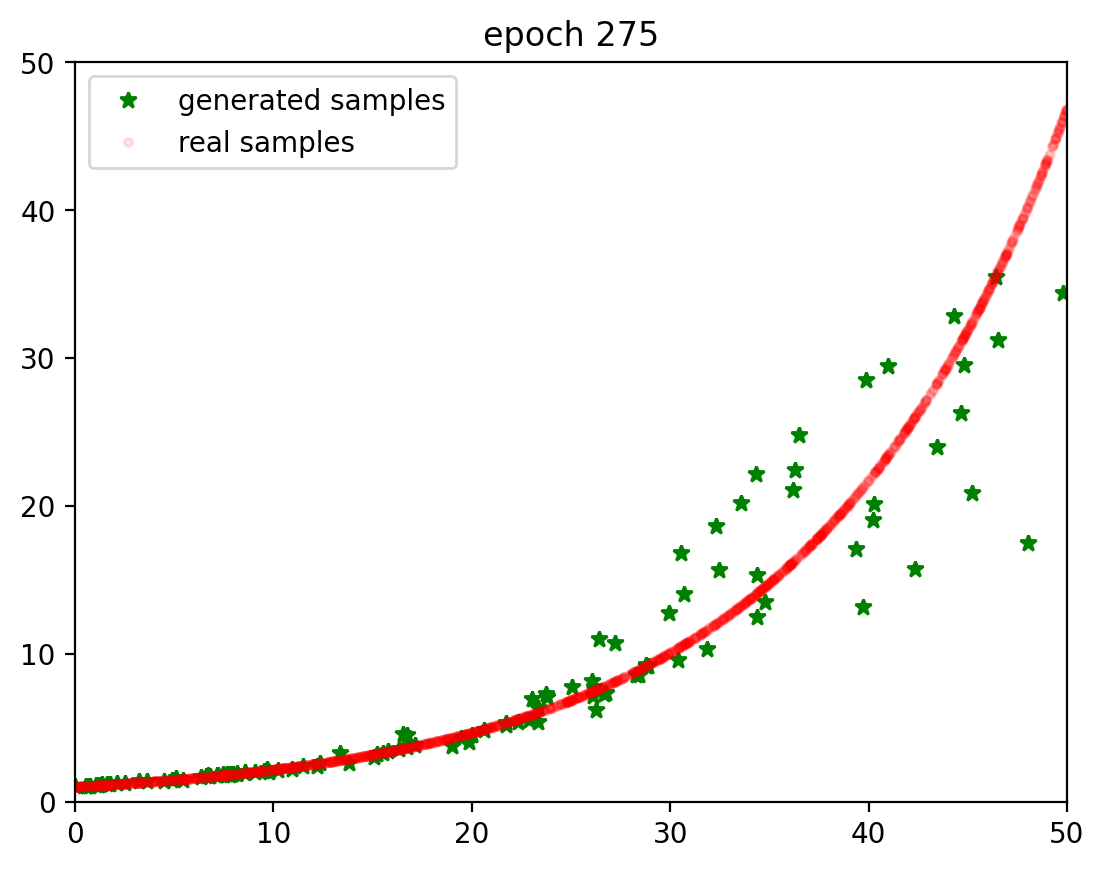

at epoch 300, G loss: 0.7739570617675782, D loss 1.4761512756347657


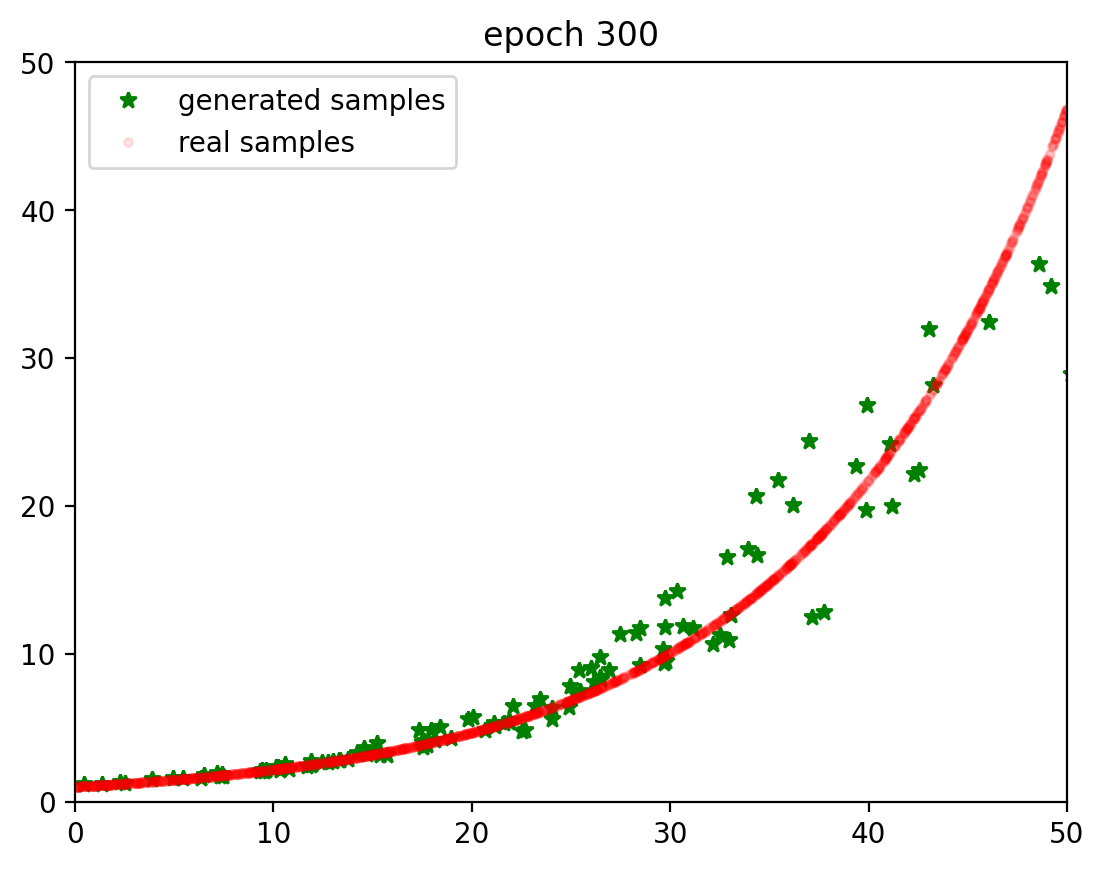

at epoch 325, G loss: 0.7676260630289714, D loss 1.4782596588134767


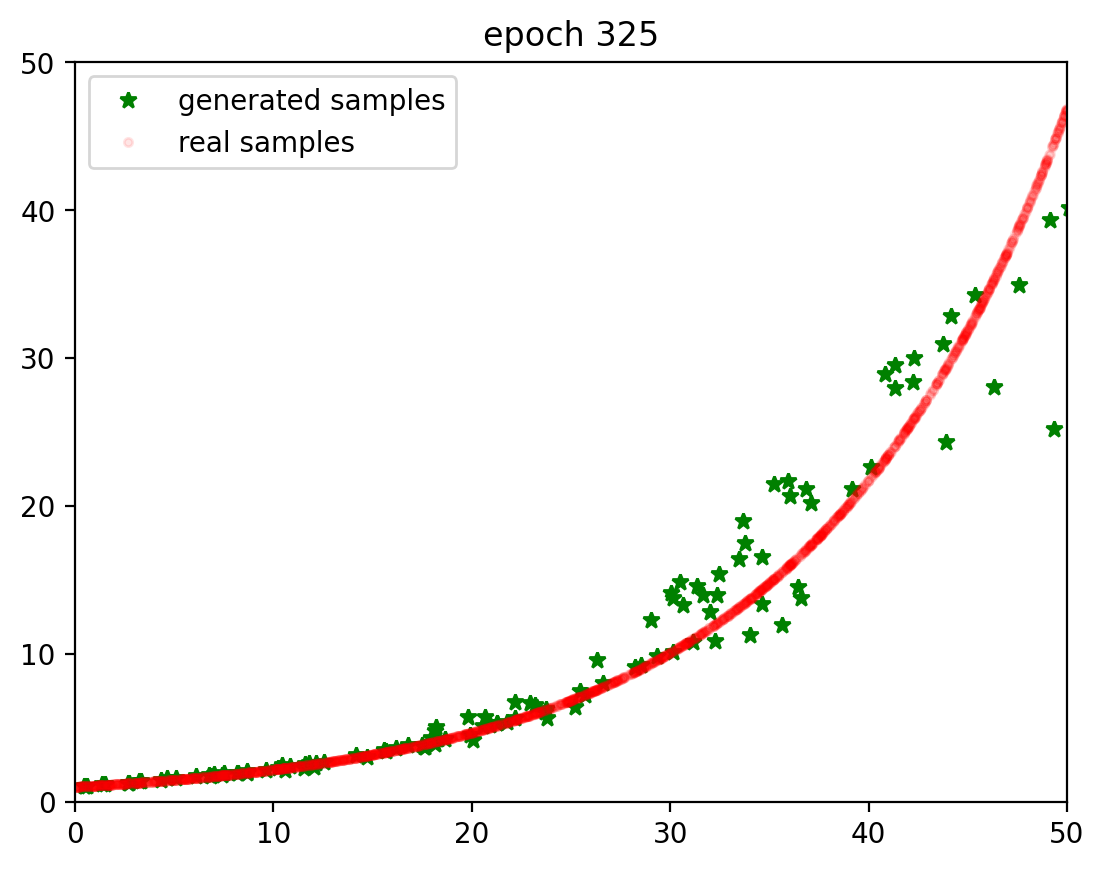

at epoch 350, G loss: 0.7609536488850911, D loss 1.4800429026285806


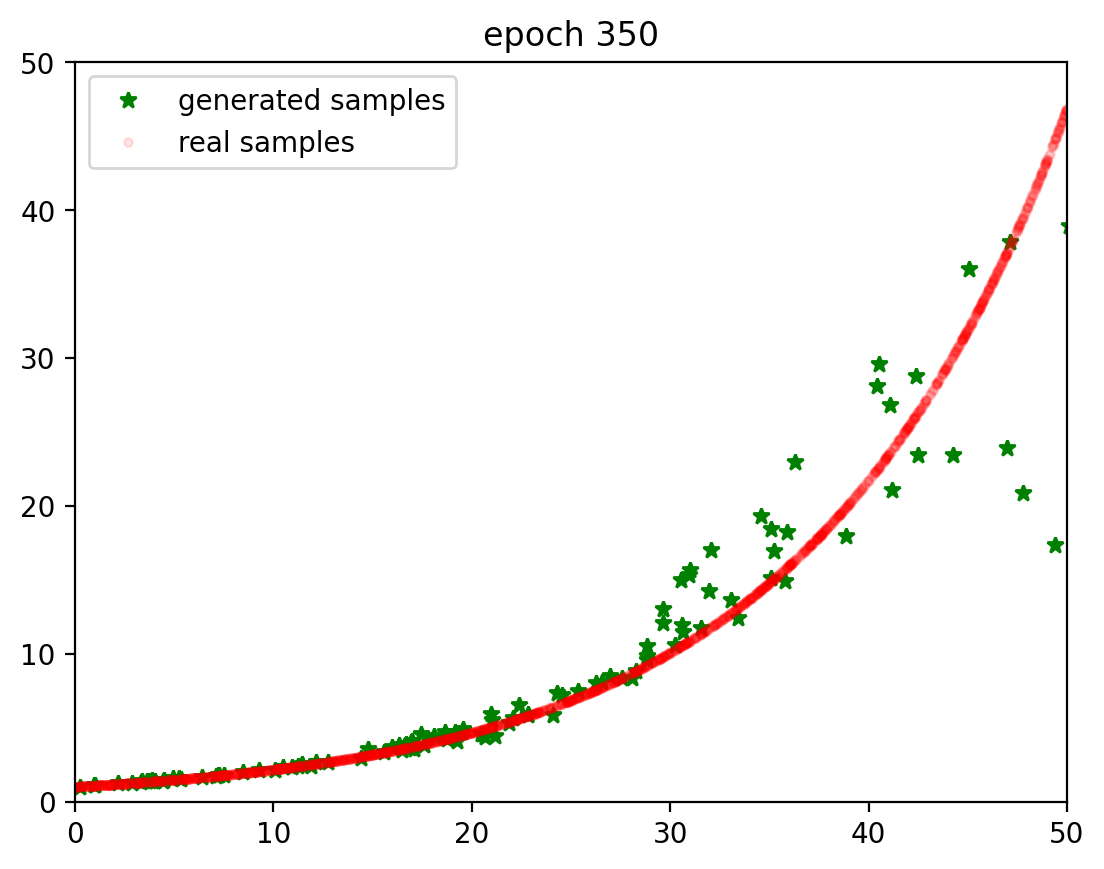

at epoch 375, G loss: 0.748401959737142, D loss 1.478997802734375


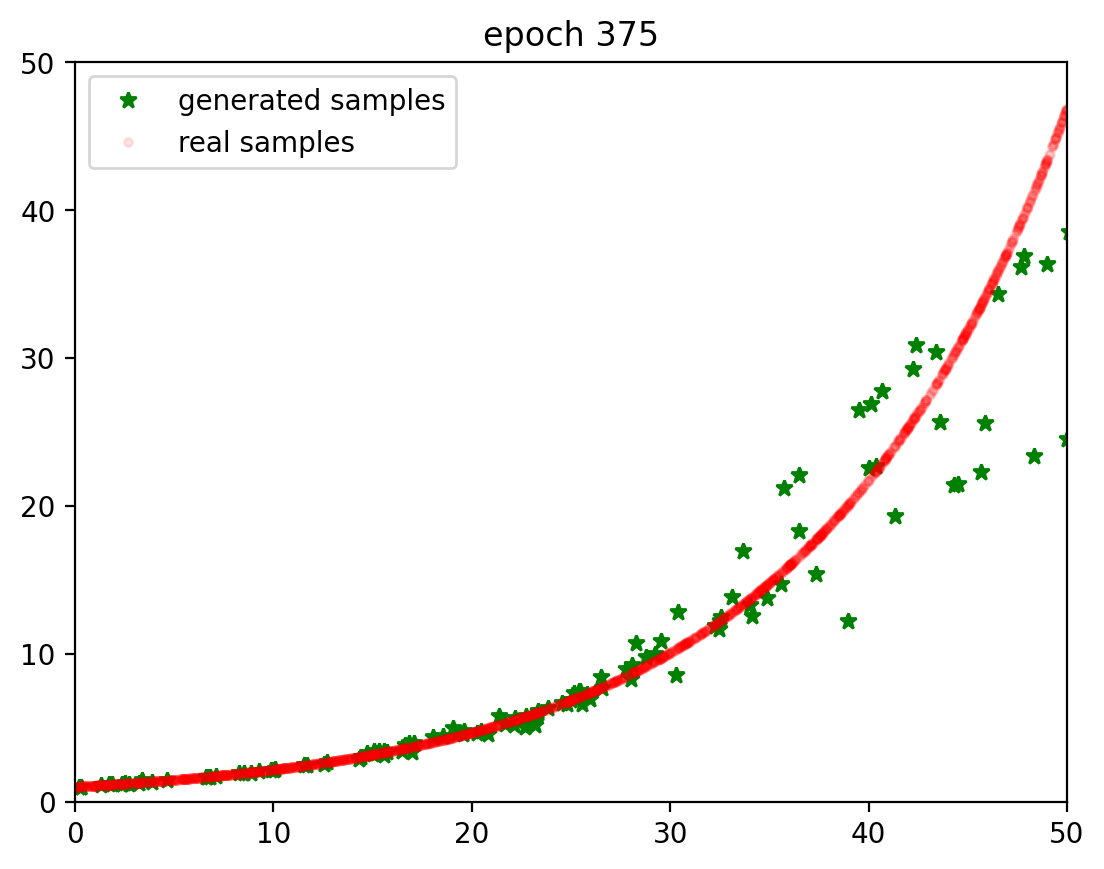

at epoch 400, G loss: 0.7664497375488282, D loss 1.4762532552083334


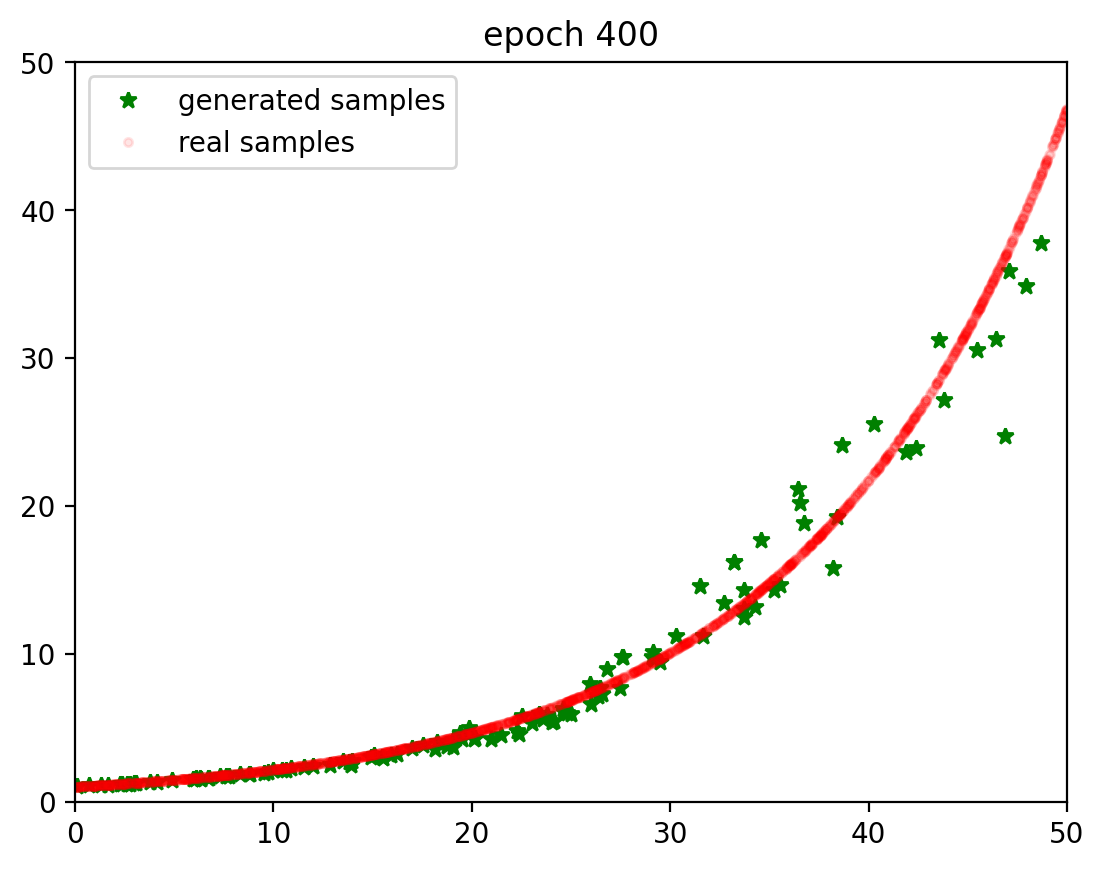

at epoch 425, G loss: 0.7587004979451497, D loss 1.4738295237223307


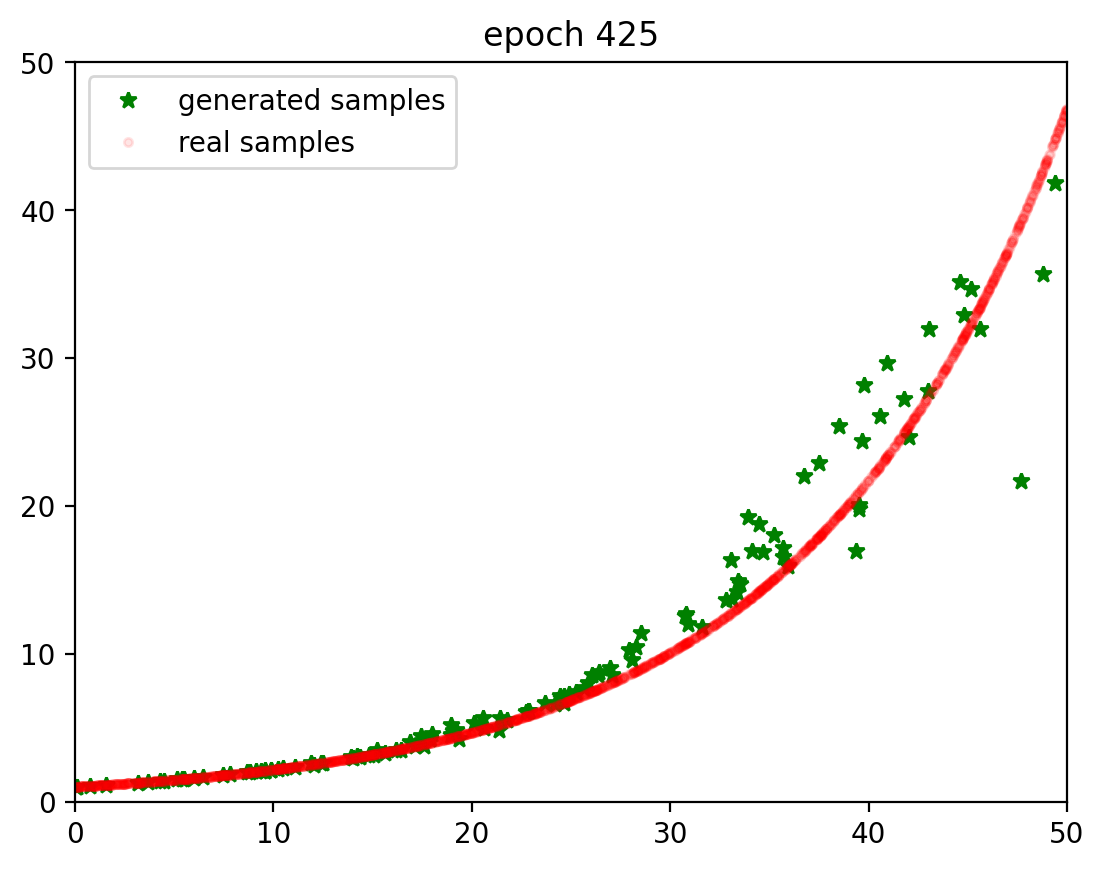

at epoch 450, G loss: 0.7606199900309245, D loss 1.4745614369710287


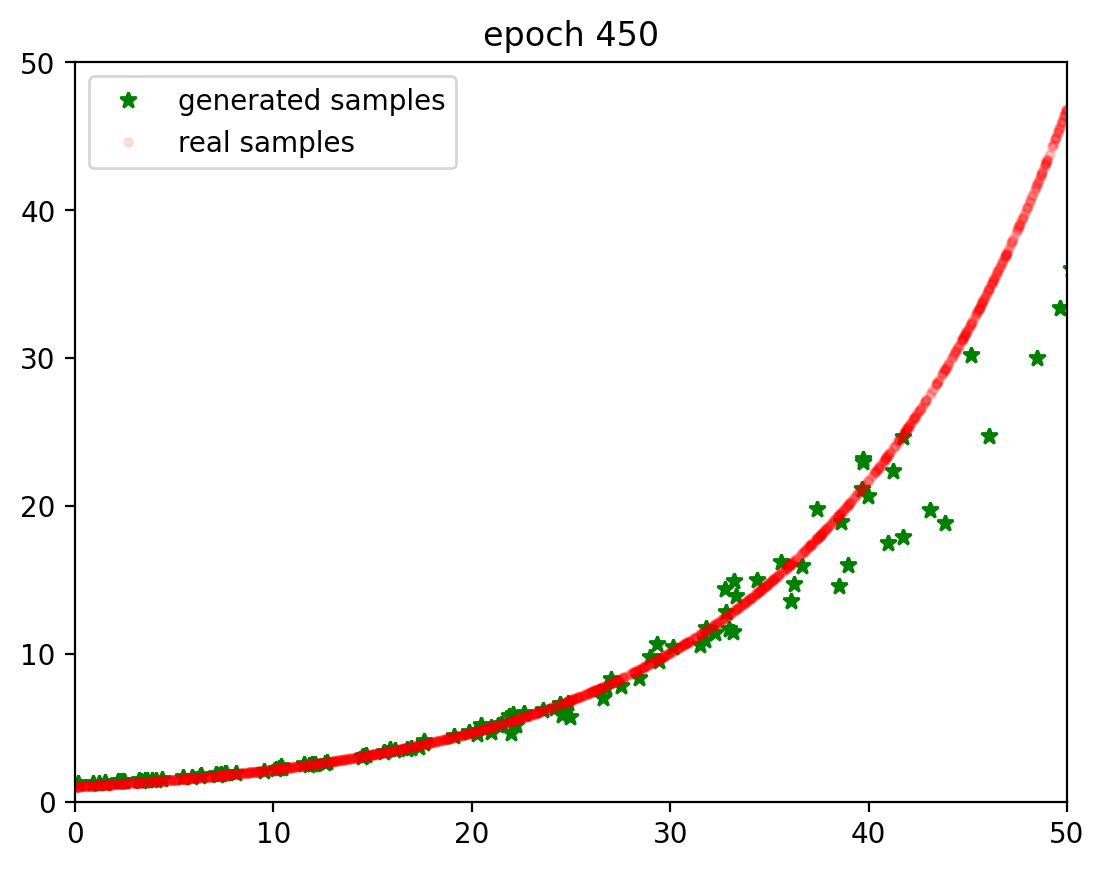

at epoch 475, G loss: 0.7506949742635091, D loss 1.4750967661539713


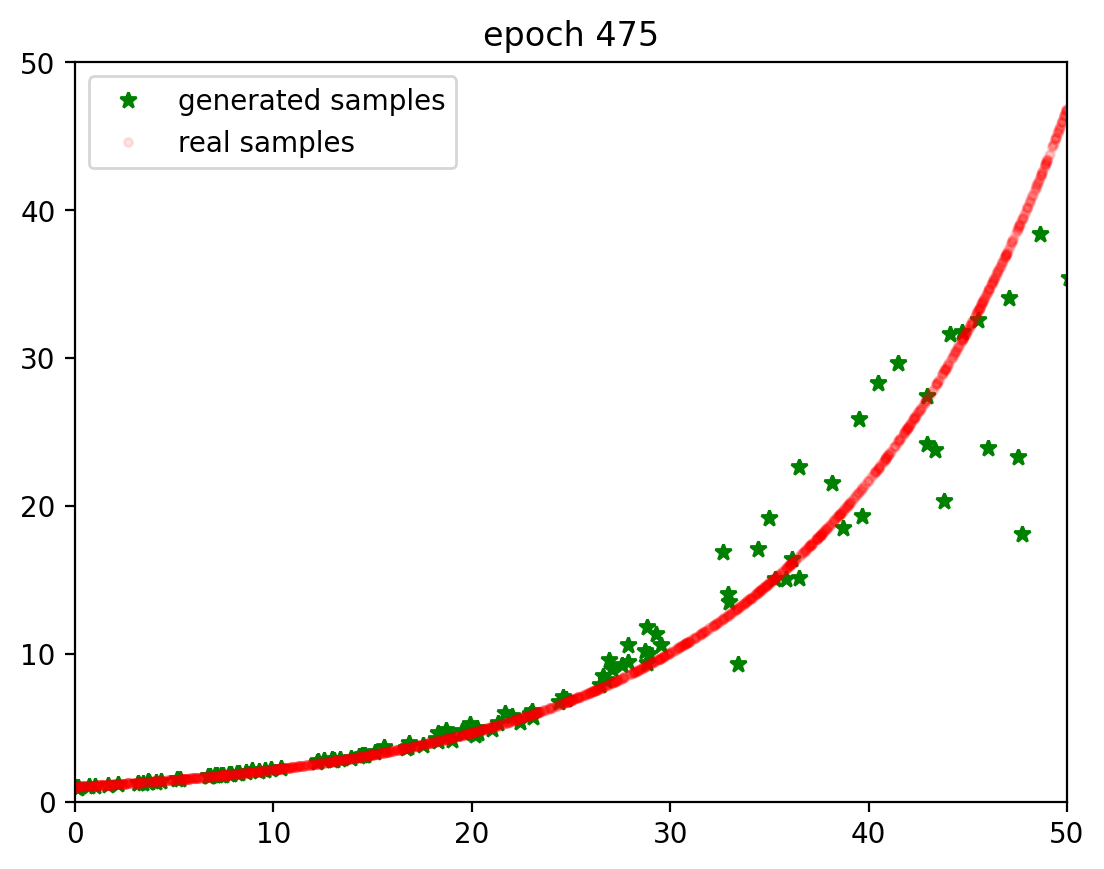

at epoch 500, G loss: 0.7456806182861329, D loss 1.4780804951985678


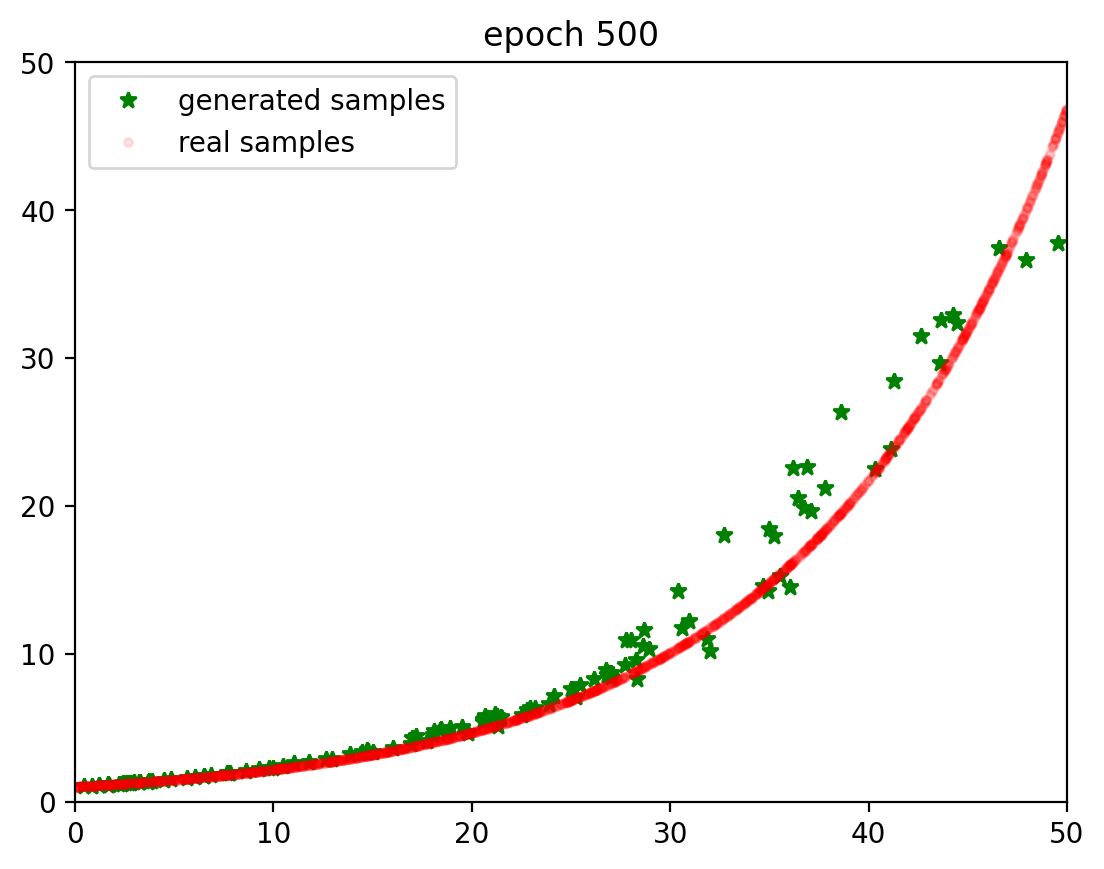

at epoch 525, G loss: 0.7508454004923503, D loss 1.4773676554361979


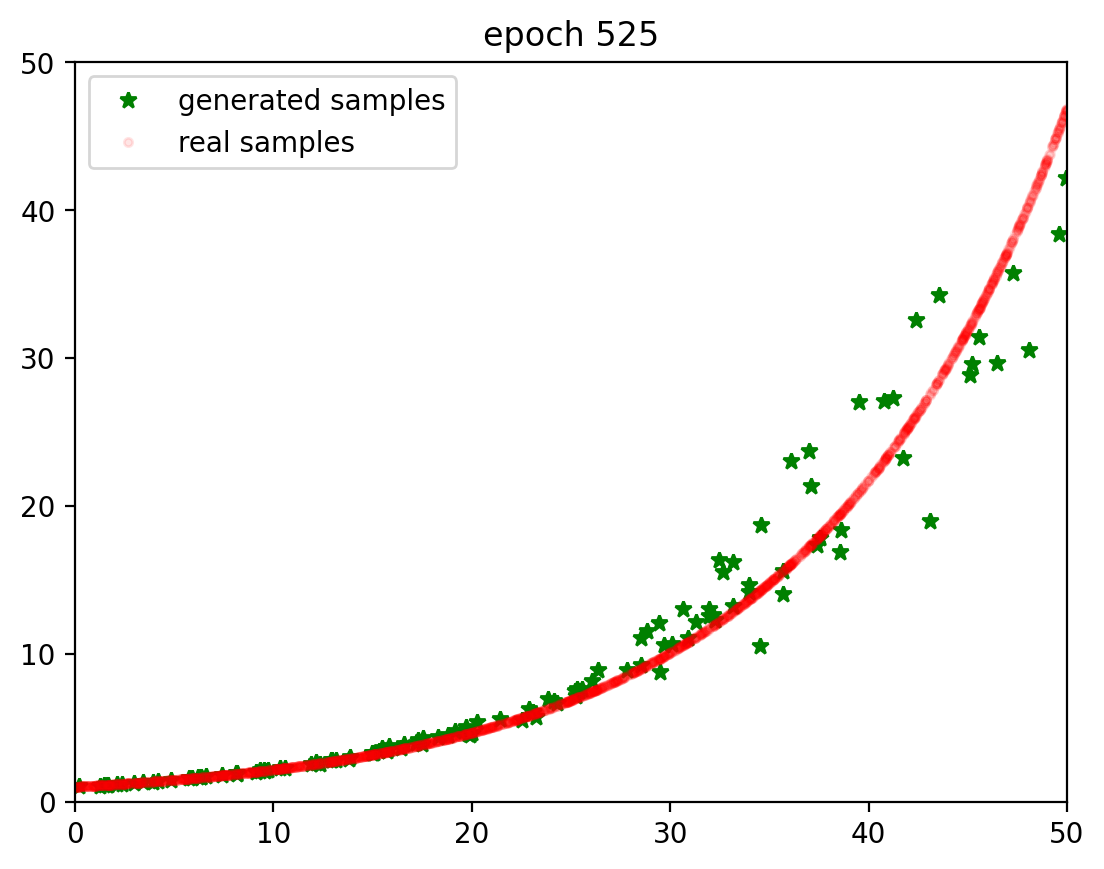

at epoch 550, G loss: 0.7451876322428386, D loss 1.472439702351888


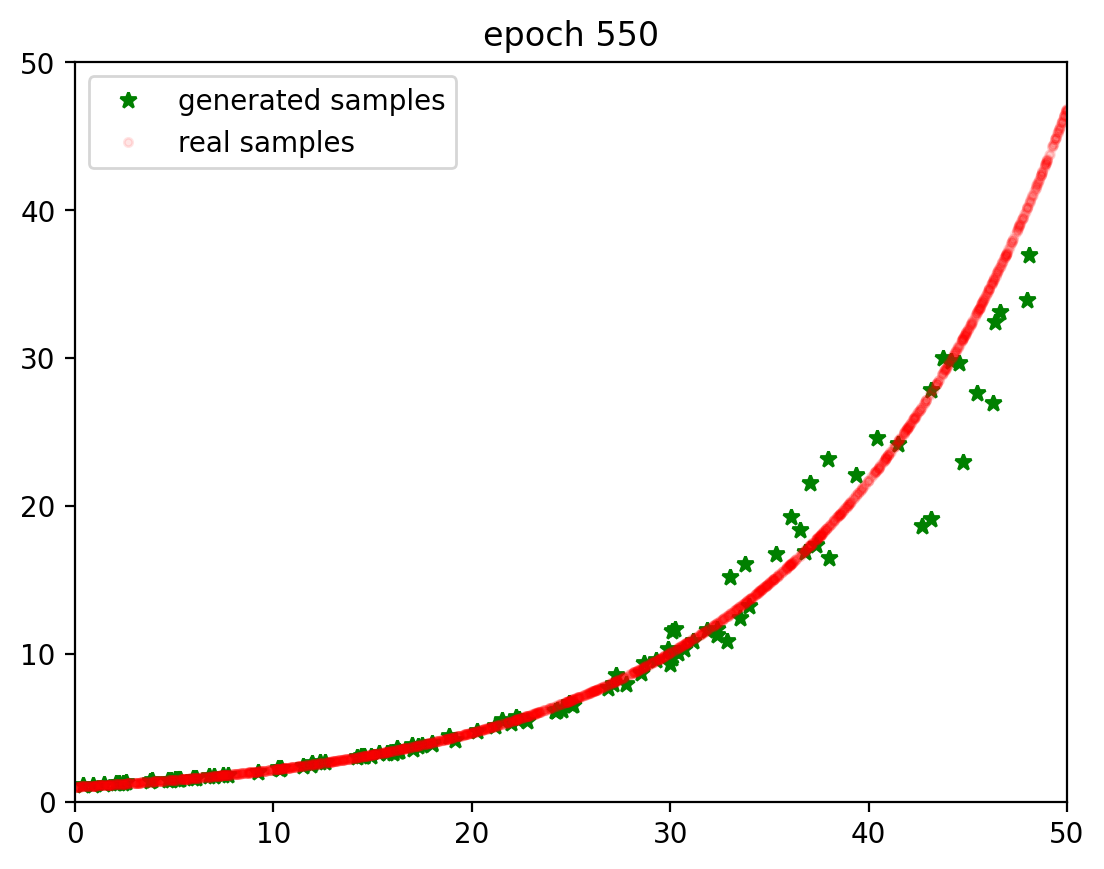

at epoch 575, G loss: 0.7440316518147786, D loss 1.4806987762451171


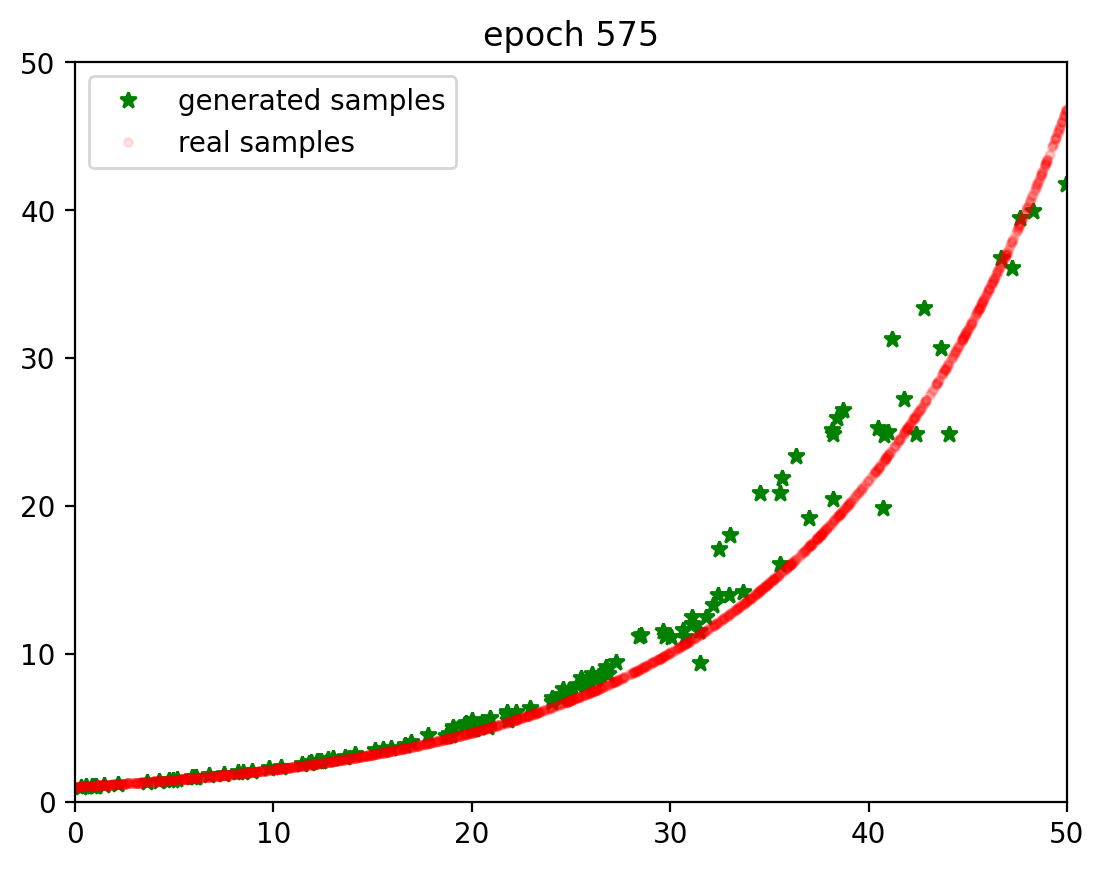

at epoch 600, G loss: 0.7545546849568685, D loss 1.4702859242757162


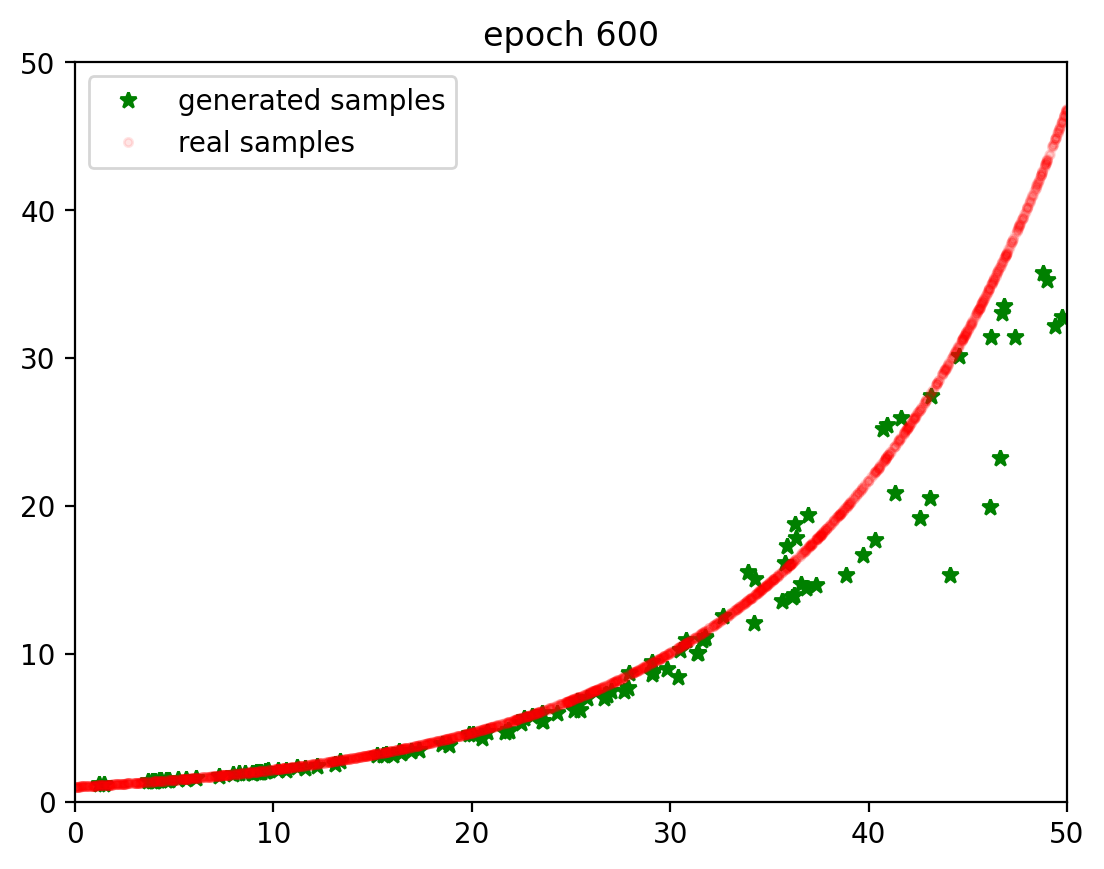

at epoch 625, G loss: 0.746086311340332, D loss 1.4758204142252604


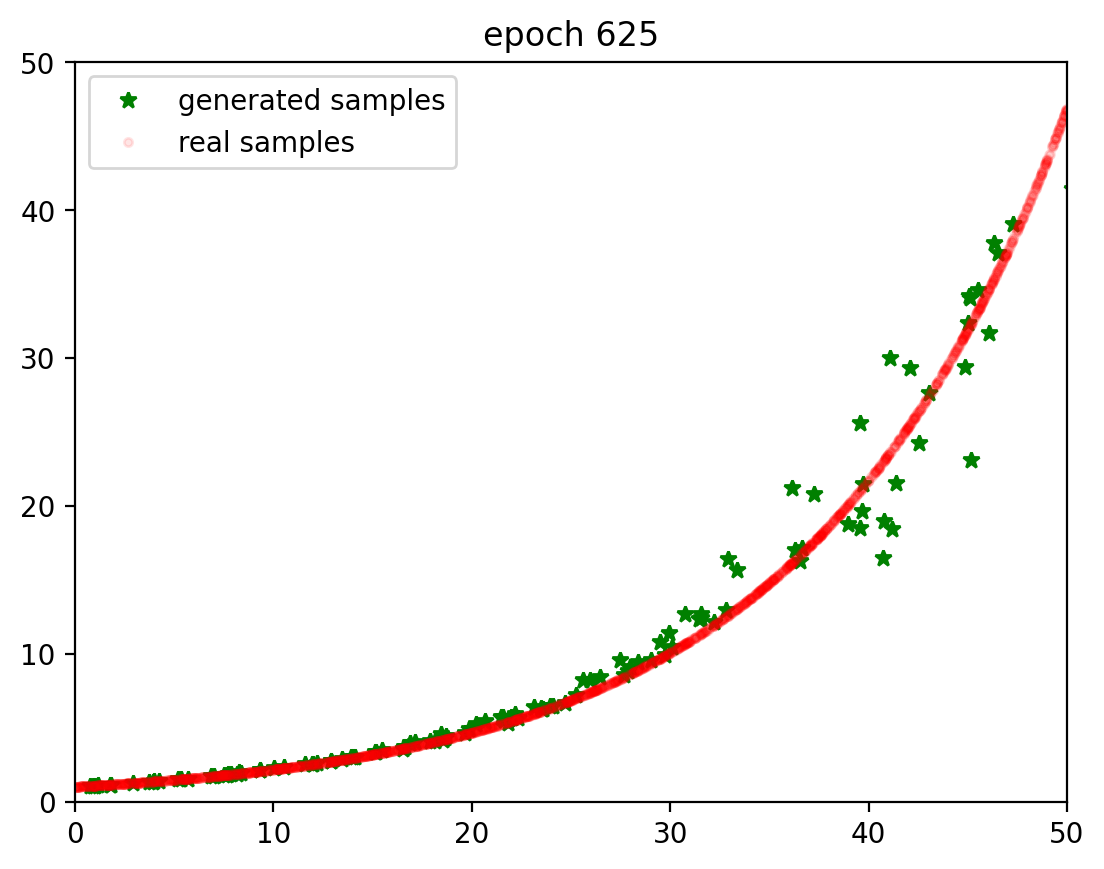

at epoch 650, G loss: 0.7475060780843099, D loss 1.4744181315104166


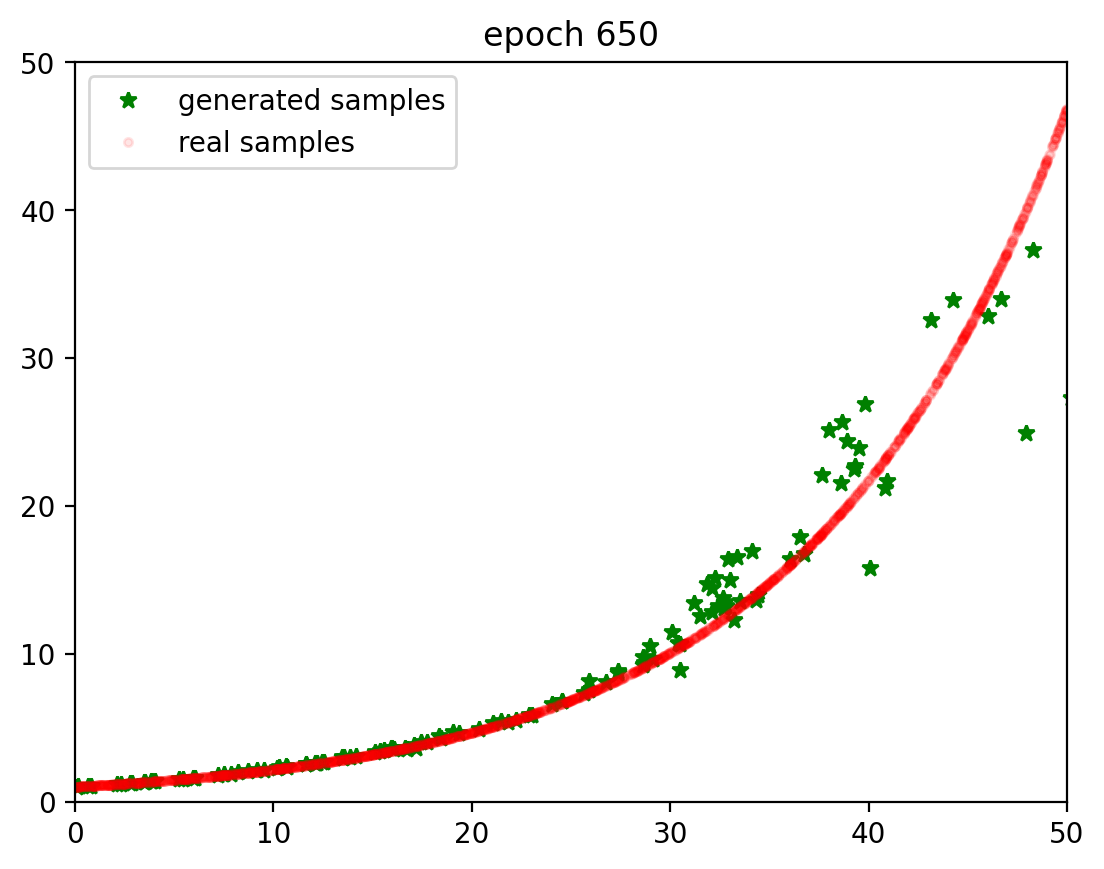

at epoch 675, G loss: 0.7690004348754883, D loss 1.4742645263671874


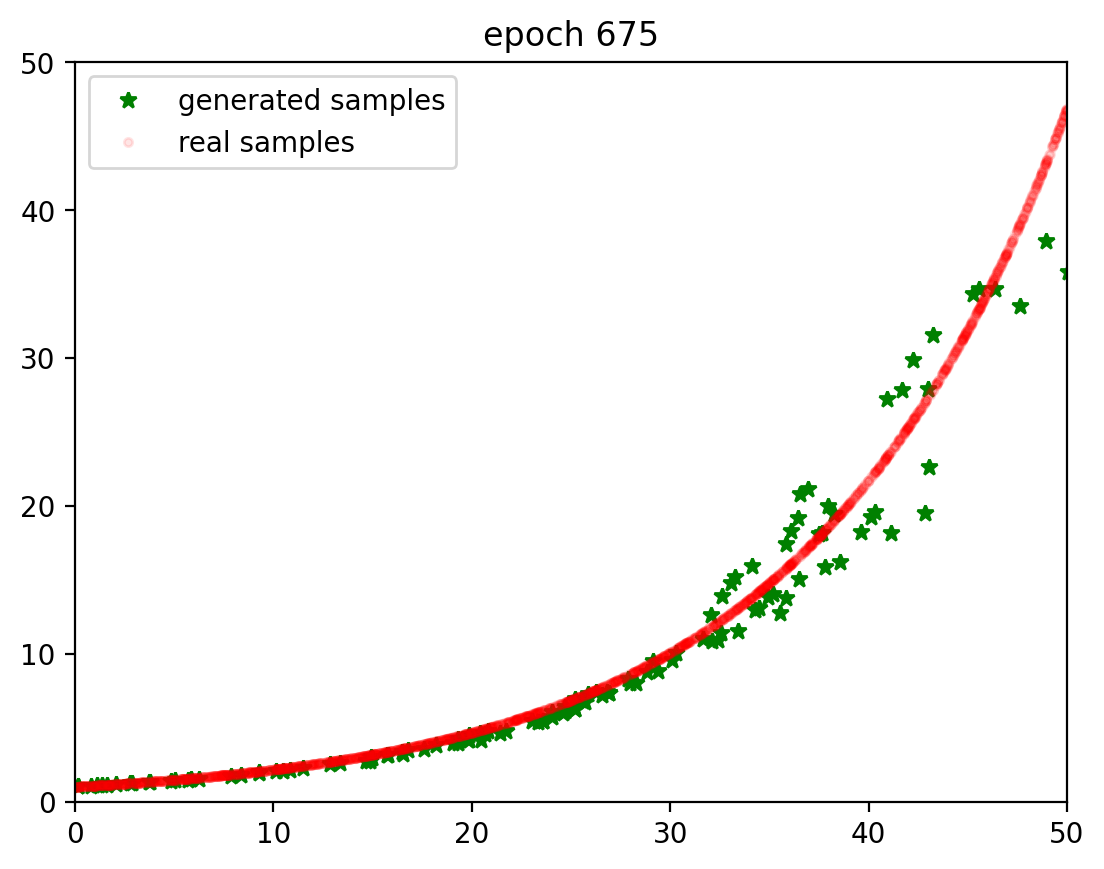

at epoch 700, G loss: 0.7577053705851237, D loss 1.473019536336263


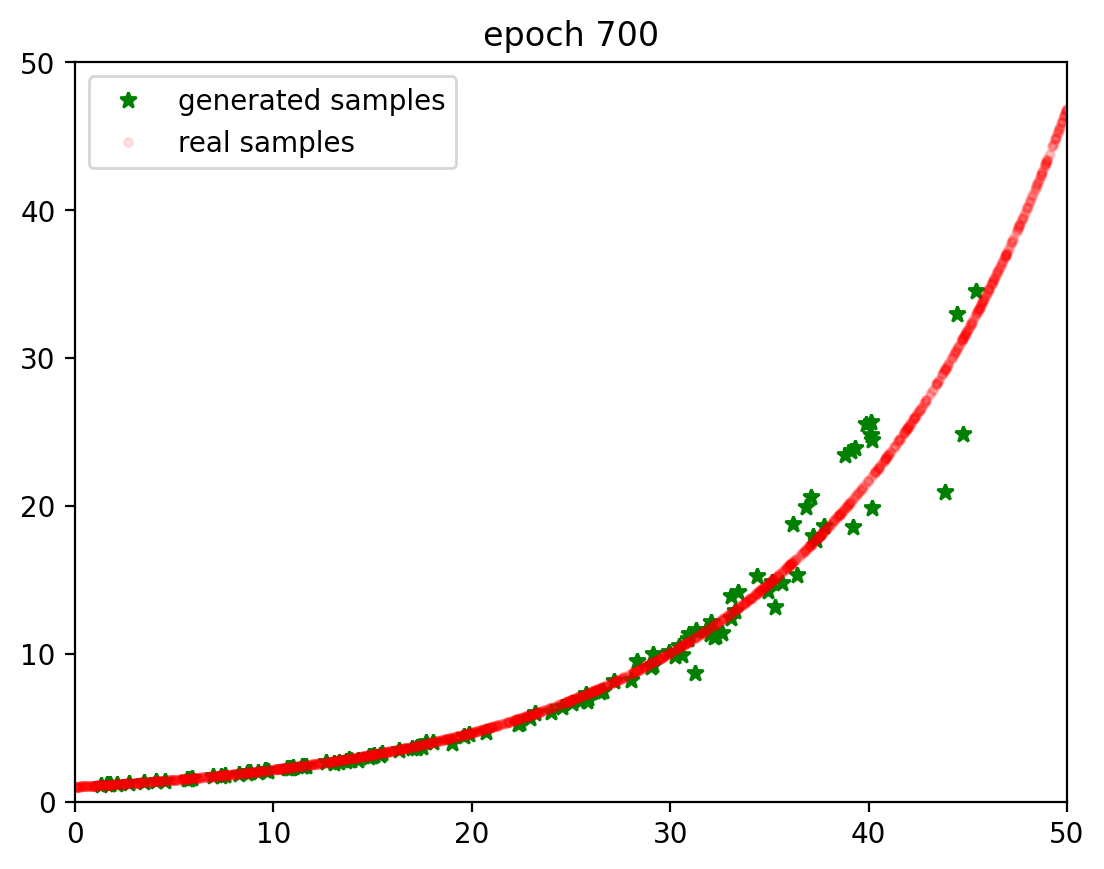

at epoch 725, G loss: 0.7584555308024089, D loss 1.4570054372151693


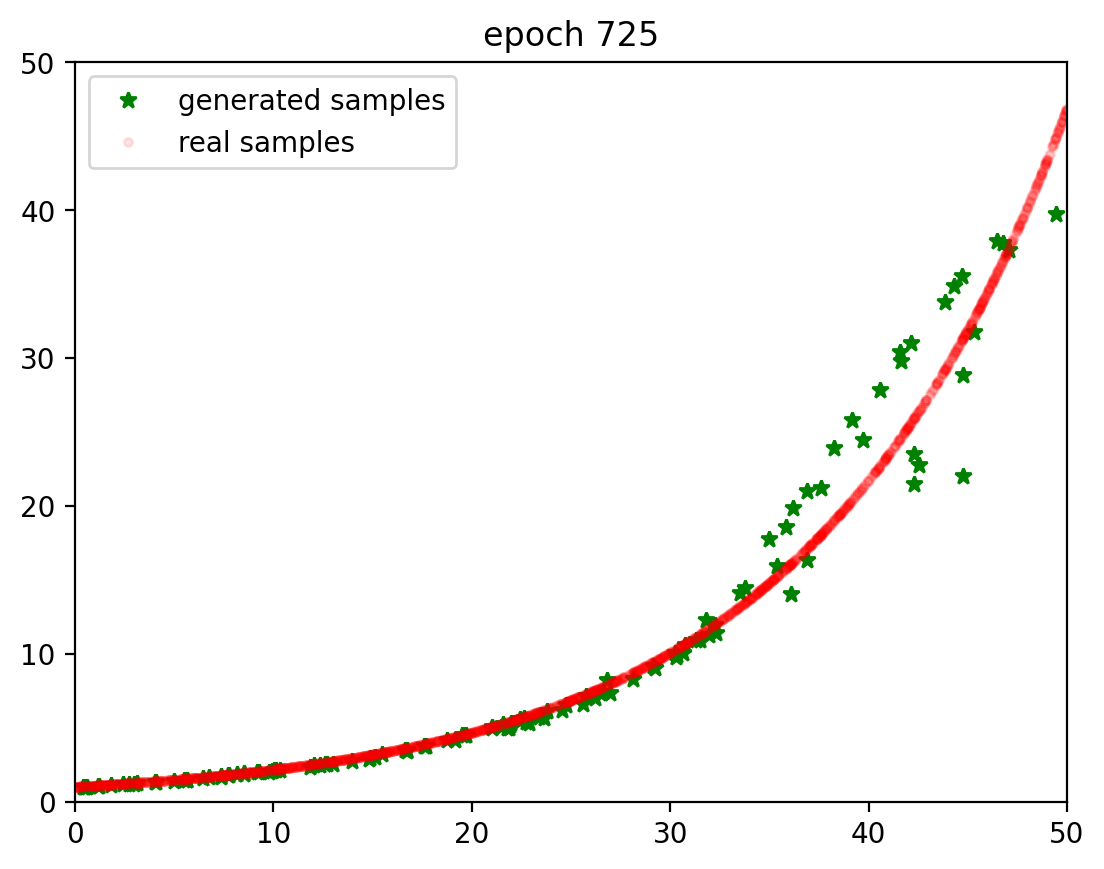

at epoch 750, G loss: 0.7717370351155599, D loss 1.455846405029297


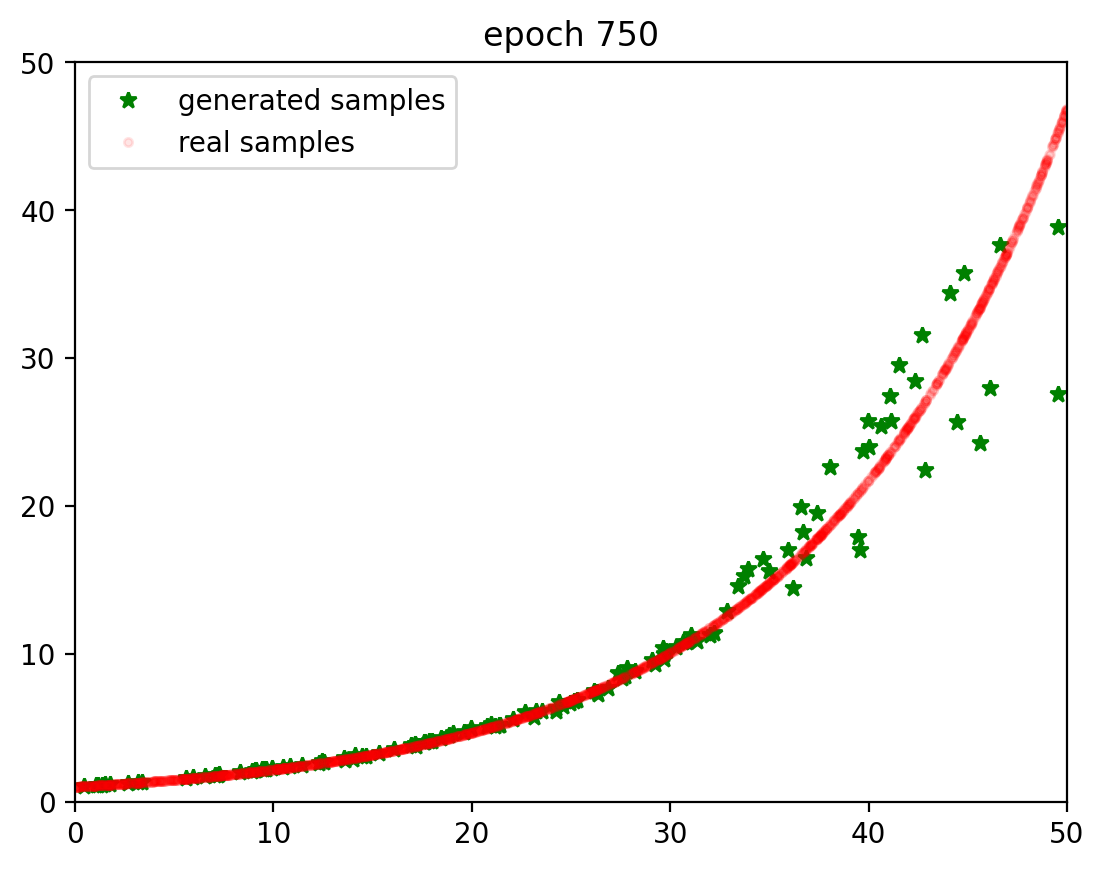

at epoch 775, G loss: 0.77732728322347, D loss 1.4686723073323569


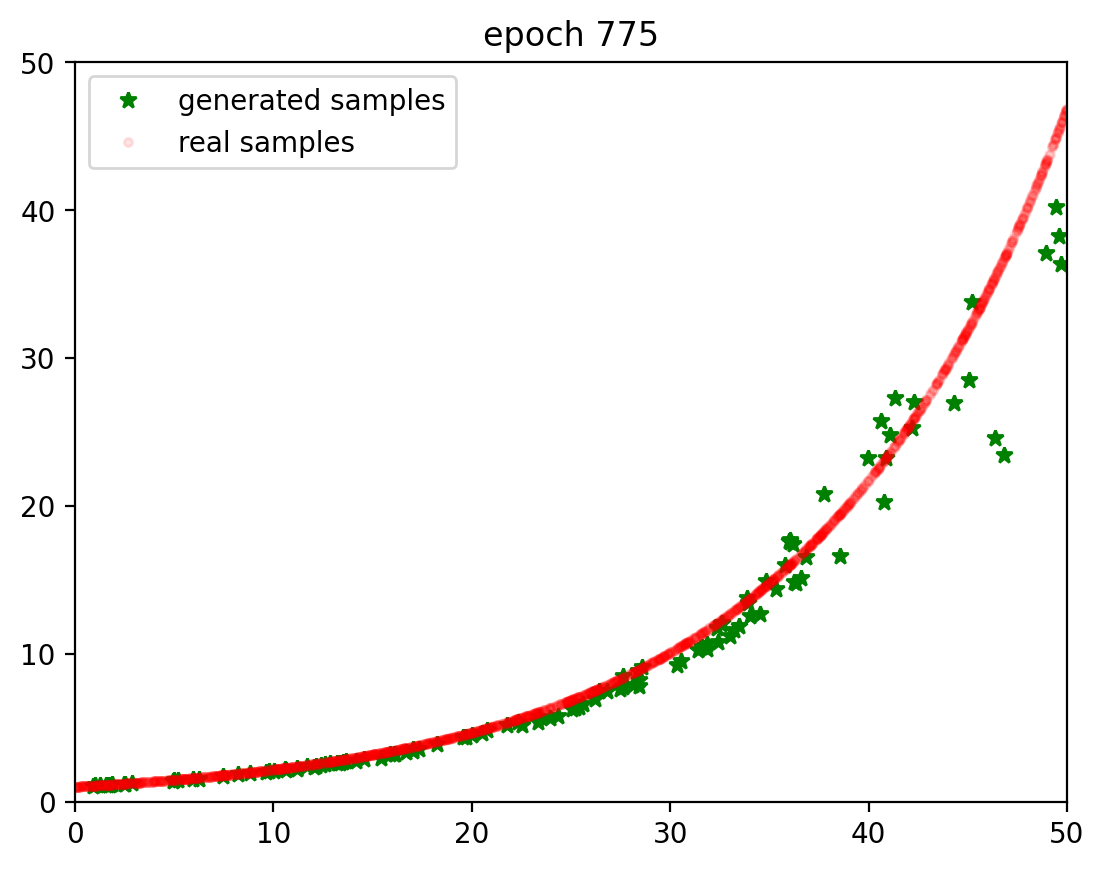

at epoch 800, G loss: 0.8058813730875651, D loss 1.4510384877522786


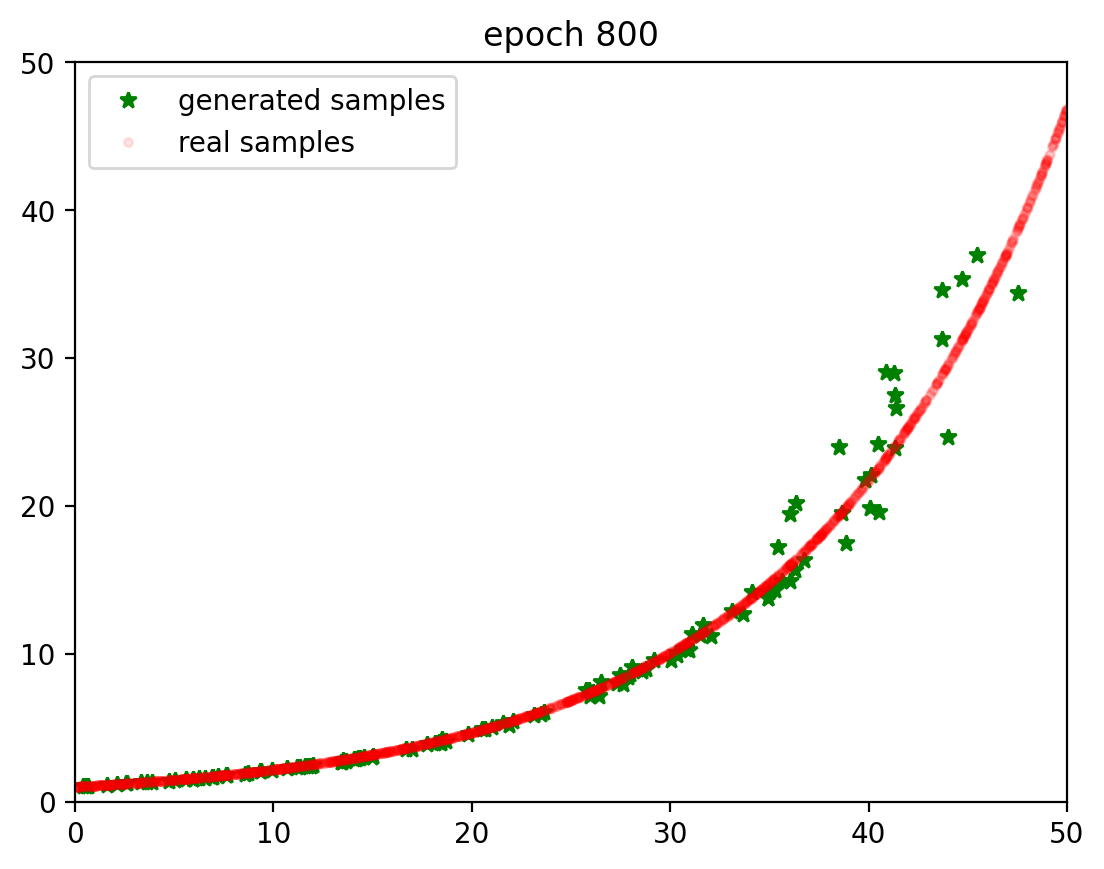

at epoch 825, G loss: 0.7661123911539713, D loss 1.4559832255045573


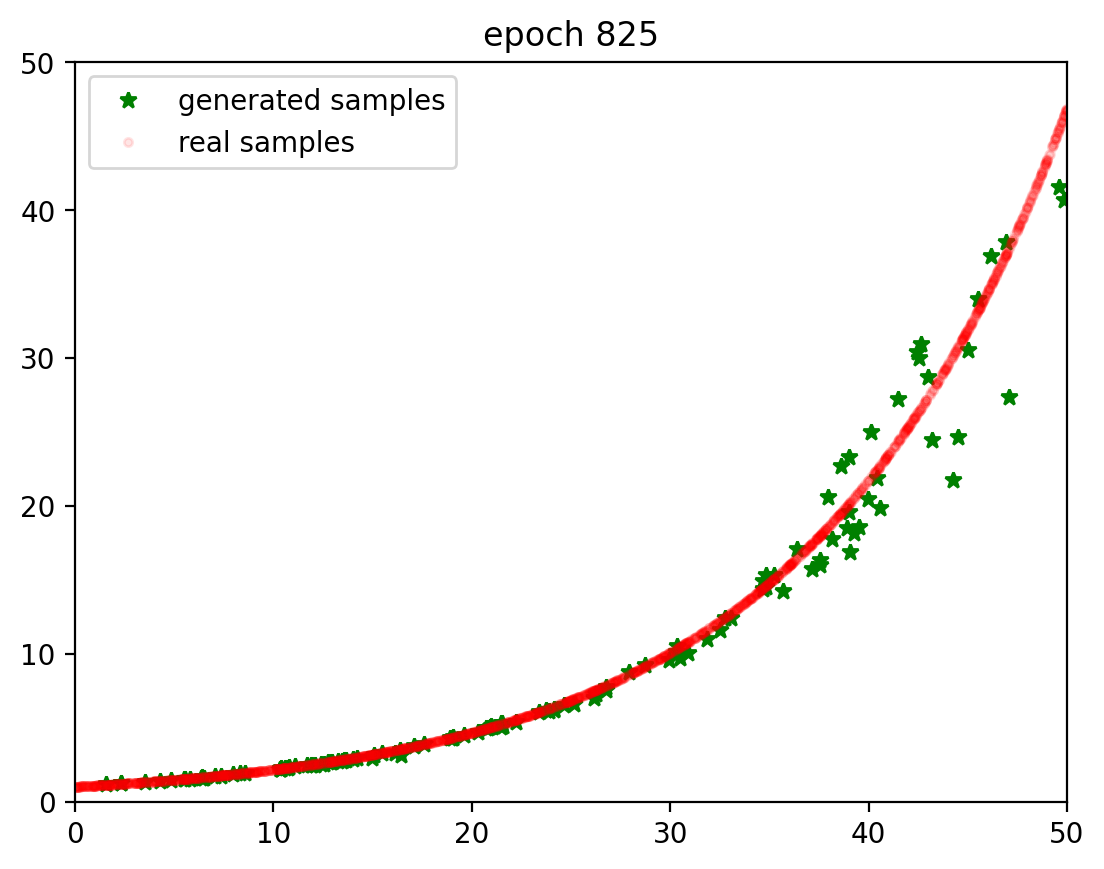

at epoch 850, G loss: 0.7789494196573893, D loss 1.4803426106770834


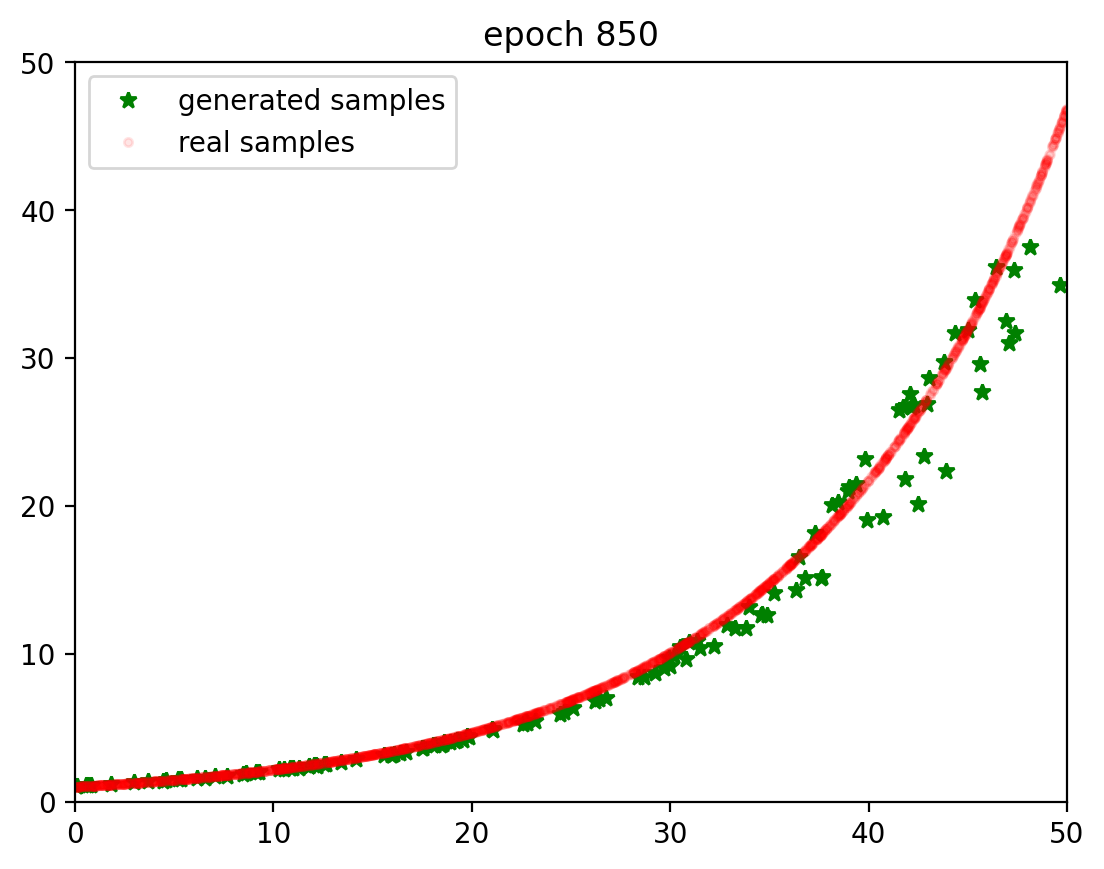

at epoch 875, G loss: 0.7920104344685872, D loss 1.4625963846842447


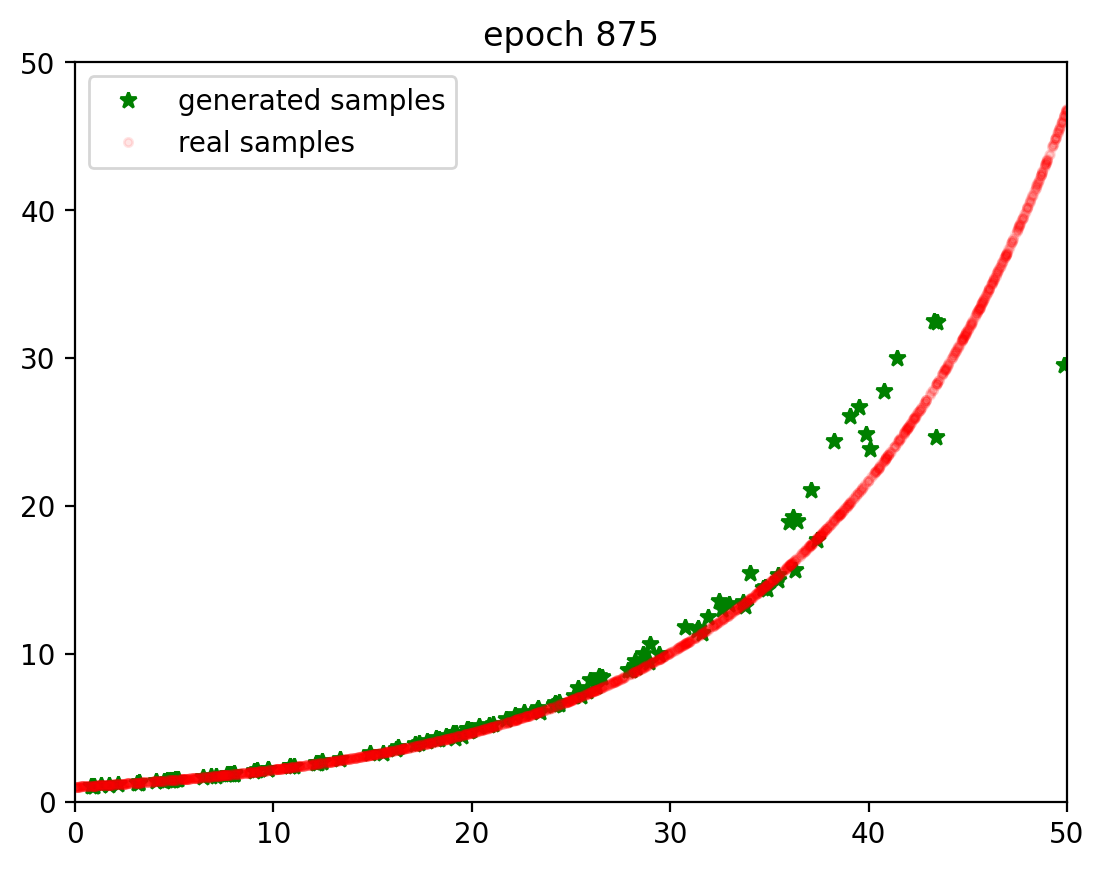

at epoch 900, G loss: 0.781384023030599, D loss 1.4523942311604818


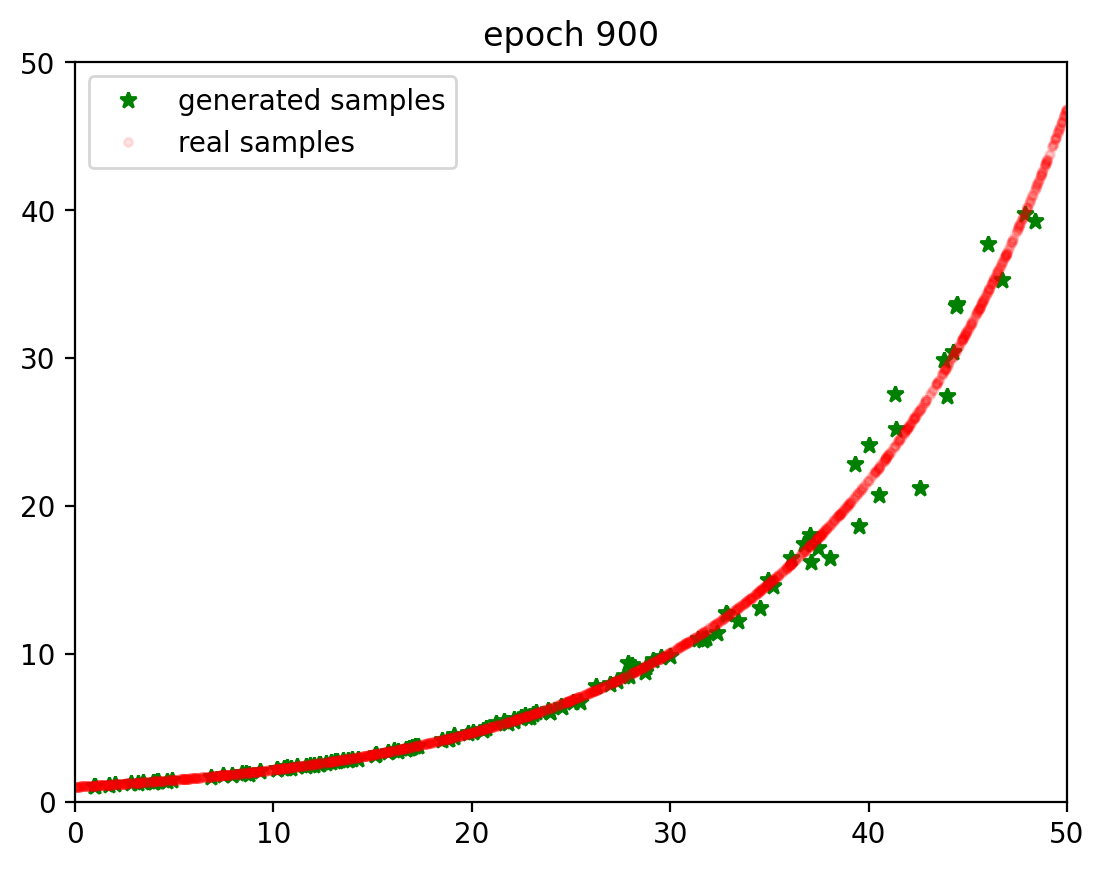

at epoch 925, G loss: 0.7816309611002604, D loss 1.4598885854085286


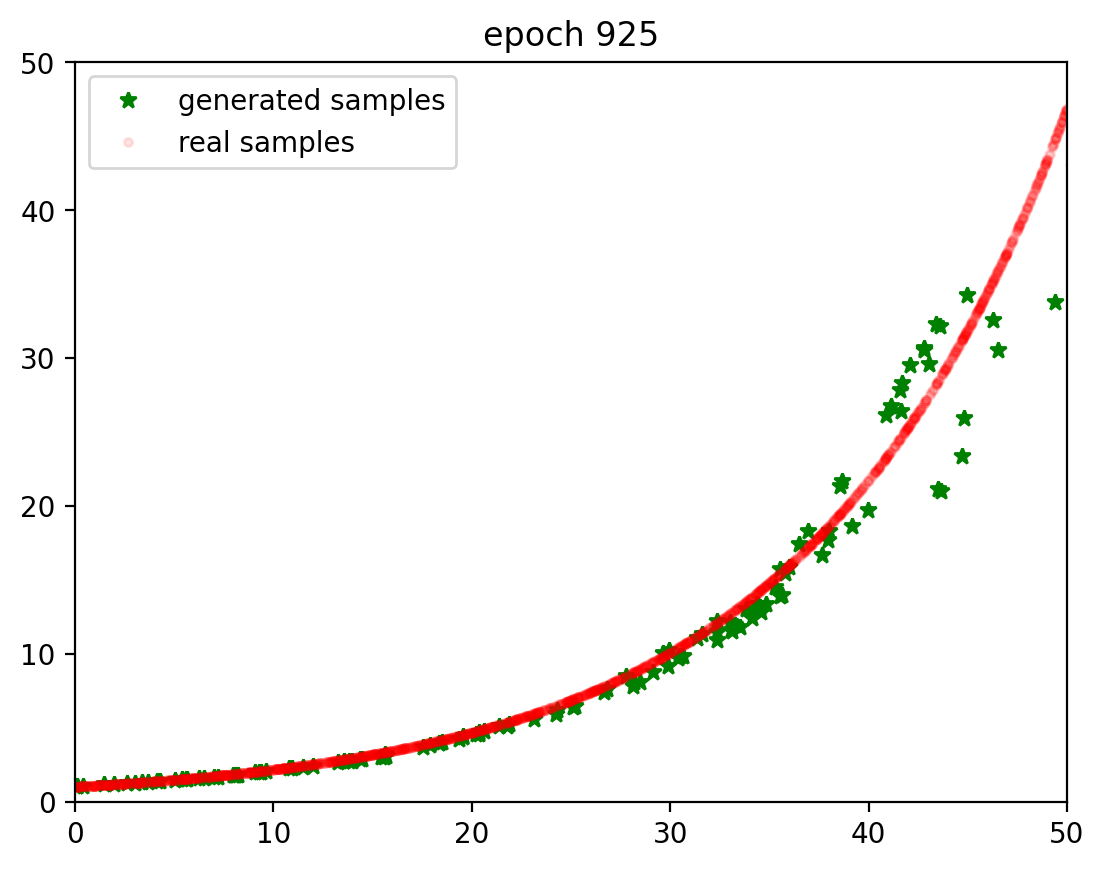

at epoch 950, G loss: 0.7812403361002604, D loss 1.4563360850016276


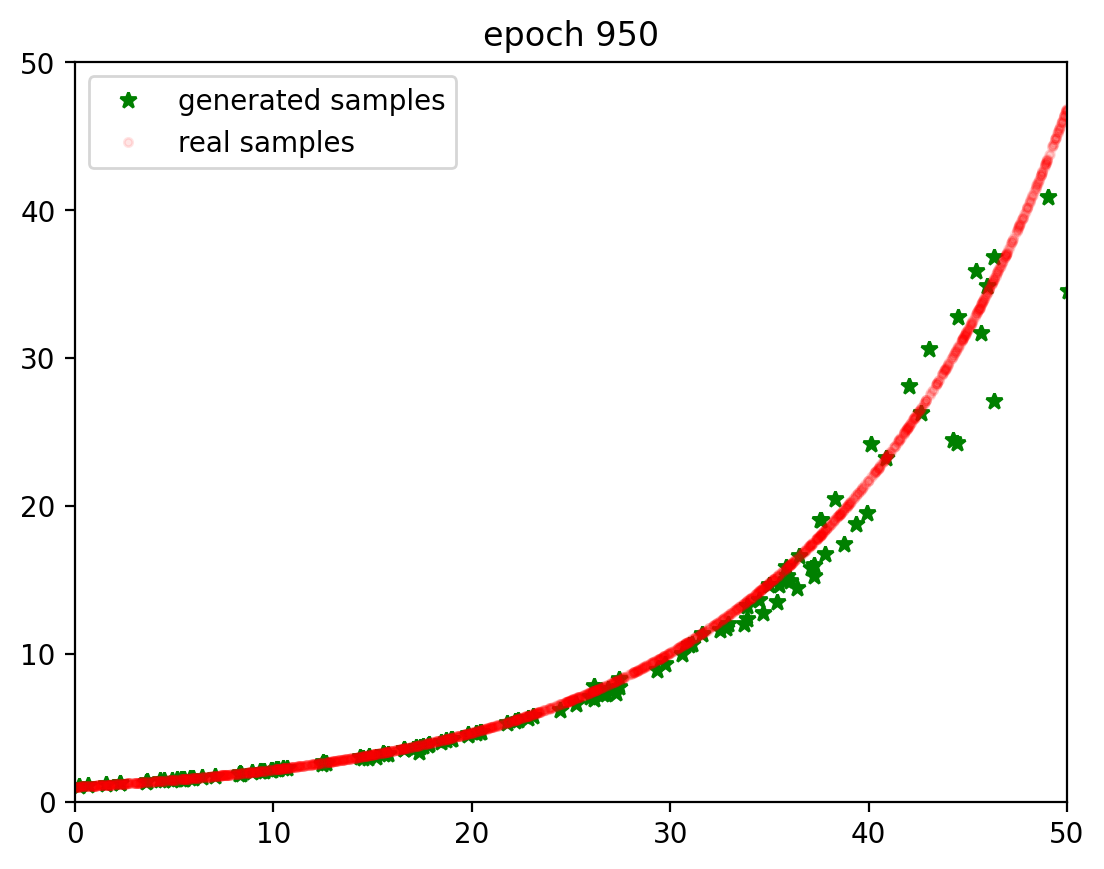

at epoch 975, G loss: 0.8940102259318033, D loss 1.406005859375


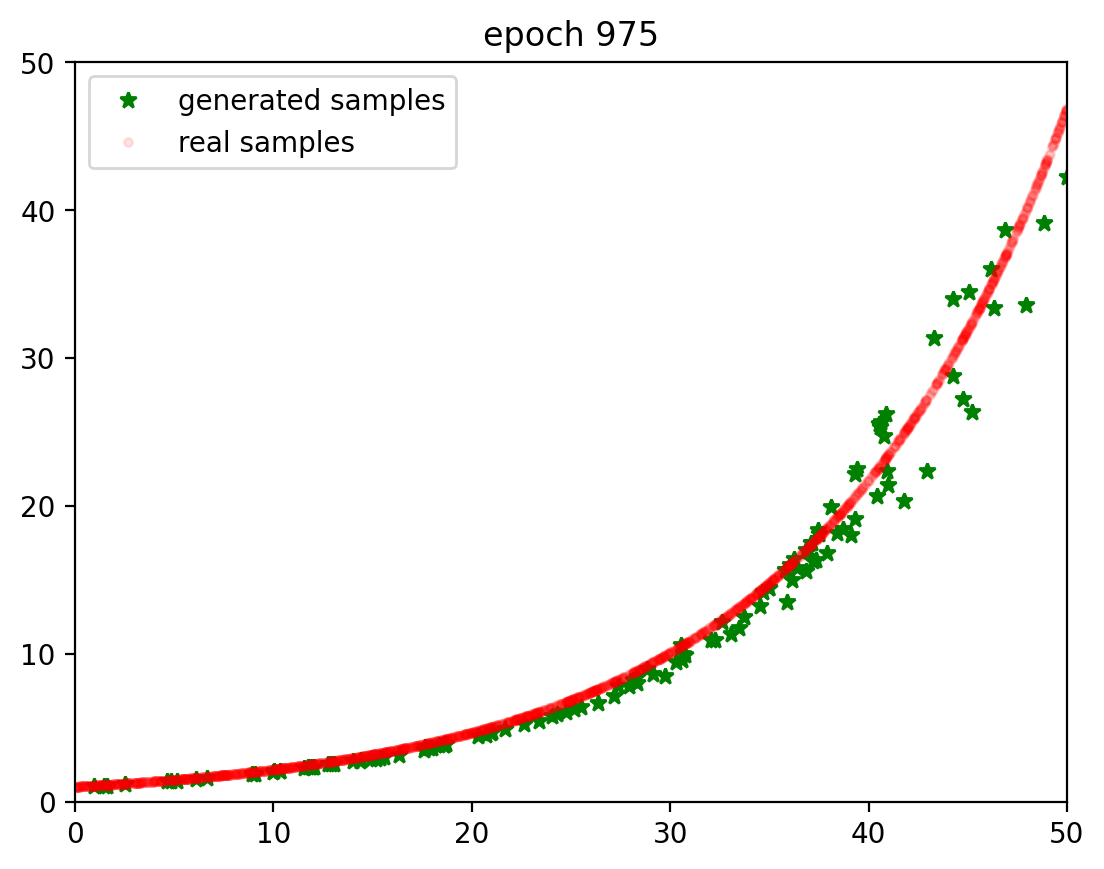

at epoch 1000, G loss: 0.8330519994099935, D loss 1.4077603658040365


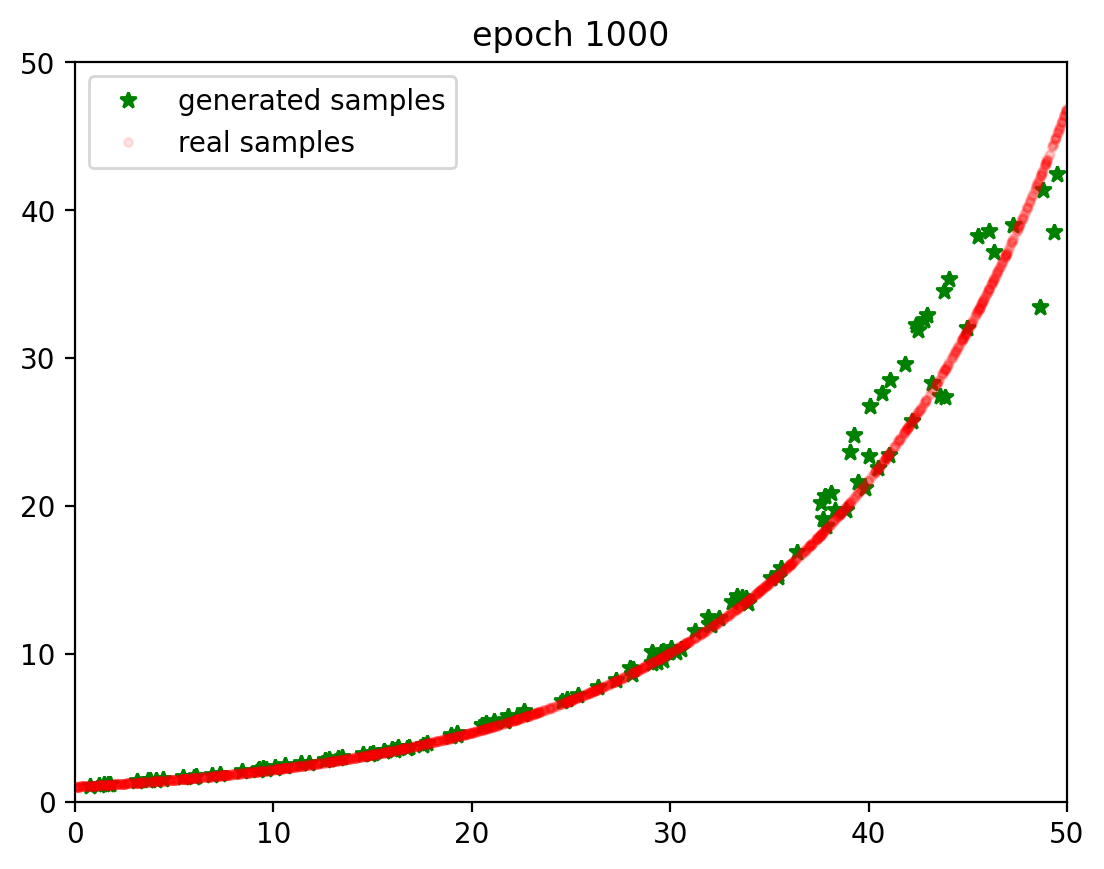

In [20]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break